# 목차
1. 분석 방향
2. 데이터 Overview
   + 속성
   + 데이터 크기
4. 데이터 전처리
   + 중복 제거
   + 결측치 처리
   + 데이터 변환
     + 타입 변환
     + 파생 변수
5. 그래프 및 상관관계
6. 가격 예측 모델링
   + 전처리
   + 긍부정 단어 예측
   + 가격 예측
     + Ridge
     + LightGBM
     + XGBoost
     + CatBoost(보류)
     + RandomForest(보류)
   + 최종 모델

---------------
# 1. 분석 방향

1. 카테고리, 브랜드의 결측 여부를 표시하는 피쳐를 새롭게 생성한다.
2. train, test 데이터를 활용(같은 이름을 찾아서)하여 결측치를 최대한 입력한다.
3. 데이터를 분석해보고 가설을 입증한다.

## 가설
+ 제품 컨디션이 좋을수록 가격이 높다  
   → 좋은 상품일수록 가격이 높고 사용감이 많은 경우엔 가격이 낮을 것<br><br>
+ 설명 길이가 길면 신뢰도가 올라가 가격이 높다  
   → 판매자가 다양한 정보나 구체적으로 설명을 작성한 상품이라면, 구매자의 신뢰도가 높아지고 상품에 대한 가치도 올라갈 것<br><br>
+ 여성/키즈 제품이 가장 많이 팔릴 것이다  
   → 중고 거래를 많이 사용하는 사용자는 여성이니 사용자층에 맞는 카테고리 제품이 많이 팔릴 것<br><br>
+ 배송비 주체가 구매자이면 금액은 낮다.  
   → 배송비+상품비까지 구매자가 감당해야되는 부분이니 상품비도 낮을 것으로 예상
   → 한국은 판매자가 배송비를 부담하는 경우가 적으니 일본도 구매자가 대부분 배송비를 부담했을 것

## 추가가설
+ 카테고리마다 원하는 제품 설명(’name’,’brand’,’item_description’) 방식이 있고, 그 설명이 가격과 연결될 것이다.

## 궁금증
1. 가격에 따라 판매에 걸릴 시간에 대한 확률 제공 -- 시간 데이터가 없어서 알기 힘듦
2. 팔고자 하는 제품의 가격을 제안하는 서비스(진품명품 같은?)
3. 현재 트렌드랑의 상관관계?
4. 가격이 포함되어 있으면 rm이라고 나왔다고 하는데, 그러면 가격(rm)이 붙은 이름은 어떤 상관관계를 보일까
5. 부담을 누가하냐? if 판매자 : 가격에 배송비 o / elif 구매자 : 가격에 배송비 x --> 플랫폼 수수료(약 10%)가 있으니, 플랫폼 운영자 입장에서는 판매자가 부담하는 게 더 좋다. --> 판매자 부담하면서, 다양한 배송 옵션을 제공해주면?
6. 적절한 카테고리를 지정해주는게 가격에 영향이 있을까? --> 이름과 카테고리의 공통점이 있다면 더 잘 팔리지 않을까? or 이름에 카테고리에 포함된 게 있으면 자동으로 분류?
7. 카테고리가 세분화될수록 가격이 높아질까?
8. 카테고리, 브랜드, 아이템 설명에 결측치가 있는데, 복원하고 결측 여부에 대한 새로운 컬럼을 만들기
9. 제목에 다양한 정보가 포함되어 있으면 가격을 높게 받을 수 있을까?

--------------
# 2. 데이터 Overveiw

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.sparse import hstack

In [3]:
mercari_df=pd.read_csv('train.tsv',sep='\t')
test_df=pd.read_csv('test_stg2.tsv',sep='\t')

In [4]:
mercari_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
mercari_df.describe(include='all')

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.482535e+06,1482535,1.482535e+06,1476208,849853,1.482535e+06,1.482535e+06,1482529
unique,NaN,1225273,NaN,1287,4809,NaN,NaN,1281425
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,2232,NaN,60177,54088,NaN,NaN,82489
mean,7.412670e+05,NaN,1.907380e+00,NaN,NaN,2.673752e+01,4.472744e-01,NaN
std,4.279711e+05,NaN,9.031586e-01,NaN,NaN,3.858607e+01,4.972124e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.706335e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.412670e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111900e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


## 스키마 분석

mercari 관련 데이터에서는 아래와 같은 속성을 가지고 있습니다.  
분석에서는 영어의 카테고리가 사용되었지만, 이해를 돕기 위하여 한글화된 속성 명칭으로 보고서를 작성하였습니다.

### 속성

1. train_id : 거래 ID `int`
2. name : 상품 이름 `object`
3. item_condition_id : 상품 상태 `int`
    + 1 : New (새 상품)
    + 2 : Like New (거의 새 것)
    + 3 : Good (좋음)
    + 4 : Fair (보통)
    + 5 : Poor (불량 또는 부품용)
5. category_name : 카테고리 `object`
6. brand_name : 브랜드 `object`
7. price : 판매 가격 `float`
8. shipping : 배송 주체 `int`
    + 0 : 구매자 부담
    + 1 : 판매자 부담
10. item_description : 제품 설명 `object`<br><br>
### 데이터 크기
`1482535 rows × 8 columns`

--------
# 3. 데이터 전처리

## 중복 제거

In [6]:
# traind_id를 인덱스로
mercari_df=mercari_df.set_index('train_id')

In [7]:
# 중복 확인
print(mercari_df.duplicated().sum())
# 49개의 중복 데이터 발견

49


In [8]:
mercari_df=mercari_df.drop_duplicates()

## 결측치 처리 

In [9]:
# 결측치 확인
mercari_df.isna().mean()*100
# 이걸 기입 안 해서 가격이 낮은 걸 수도 있으니, 결측 여부에 대한 새로운 피쳐 생성, 기입 가능한 정보는 기입하여 카테고리에 대한 분석 강화

name                  0.000000
item_condition_id     0.000000
category_name         0.426783
brand_name           42.674332
price                 0.000000
shipping              0.000000
item_description      0.000405
dtype: float64

### category_name, brand_name

In [10]:
# 안된 값은 가격에 그러한 영향이 있을 것이다.
mercari_df['no_cate']=mercari_df['category_name'].isna().astype(int)
mercari_df['no_brand']=mercari_df['brand_name'].isna().astype(int)

#### 동일 이름에서 찾기(train.csv)

In [11]:
print(mercari_df.isna().sum())
# 찾기 이전 값

name                      0
item_condition_id         0
category_name          6327
brand_name           632641
price                     0
shipping                  0
item_description          6
no_cate                   0
no_brand                  0
dtype: int64


In [12]:
# 중복되는 상품 이름 찾기
duplicated_name_train=mercari_df[mercari_df['name'].duplicated()]['name'].unique()

# 중복된 이름이면서 'category_name'이 nan값이 아닌 행들에서, 'name','category_name'만 추출, 하나의 이름만 남겨놓고 중복 제거, 이름을 인덱스로 설정, 'category_name'만 추출해서 Series로 반환
duplicated_category=mercari_df[(mercari_df['name'].isin(duplicated_name_train))&(mercari_df['category_name'].notna())][['name','category_name']].drop_duplicates(subset='name').set_index('name')['category_name']
# 'category_name'에서 결측값이 있는 행을 채운다, 어떤걸로? 반환된 시리즈를 결측치가 있는 mercari_df['name']을 키 값으로 찾아서
mercari_df['category_name']=mercari_df['category_name'].fillna(mercari_df['name'].map(duplicated_category))

# 위와 같은 작업, brand_name
duplicated_brand=mercari_df[(mercari_df['name'].isin(duplicated_name_train))&(mercari_df['brand_name'].notna())][['name','brand_name']].drop_duplicates(subset='name').set_index('name')['brand_name']
mercari_df['brand_name']=mercari_df['brand_name'].fillna(mercari_df['name'].map(duplicated_brand))

print(mercari_df.isna().sum())
# 브랜드 : 1203개 결측치 제거
# 카테고리 : 63773개 결측치 제거
# 이렇게 해도 안 되는 건 결측치 처리

name                      0
item_condition_id         0
category_name          5124
brand_name           568869
price                     0
shipping                  0
item_description          6
no_cate                   0
no_brand                  0
dtype: int64


#### 동일 이름에서 찾기(test.csv)

In [13]:
# 겹치는 상품 이름 찾기
duplicated_name_test=test_df['name'].unique()

duplicated_category=test_df[(test_df['name'].isin(duplicated_name_test))&(test_df['category_name'].notna())][['name','category_name']].drop_duplicates(subset='name').set_index('name')['category_name']
mercari_df['category_name']=mercari_df['category_name'].fillna(mercari_df['name'].map(duplicated_category))

# 위와 같은 작업, brand_name
duplicated_brand=test_df[(test_df['name'].isin(duplicated_name_test))&(test_df['brand_name'].notna())][['name','brand_name']].drop_duplicates(subset='name').set_index('name')['brand_name']
mercari_df['brand_name']=mercari_df['brand_name'].fillna(mercari_df['name'].map(duplicated_brand))

mercari_df.isna().sum()

name                      0
item_condition_id         0
category_name          4718
brand_name           542304
price                     0
shipping                  0
item_description          6
no_cate                   0
no_brand                  0
dtype: int64

In [14]:
def build_token_brand_map(mercari_df, min_count=20, min_ratio=0.8):
    df_known = mercari_df[~mercari_df["brand_name"].isna()]
    tokens = df_known["name_clean"].str.split()
    df_known["tok1"] = tokens.str[0]                 # 첫 단어
    df_known["tok2"] = tokens.str[:2].str.join(" ")  # 첫 두 단어
    tok_maps = {}
    for col in ["tok1", "tok2"]:
        # (토큰, 브랜드) 조합별 등장 횟수
        grp = (
            df_known
            .groupby([col, "brand_name"])
            .size()
            .reset_index(name="cnt")
        )

        # 해당 토큰의 전체 등장 횟수
        total = grp.groupby(col)["cnt"].sum().reset_index(name="total")
        grp = grp.merge(total, on=col, how="left")

        # ratio = 특정 브랜드가 tok 전체에서 차지하는 비율
        grp["ratio"] = grp["cnt"] / grp["total"]

        # 필터링: 자주 나오고 압도적 비율일 때만 인정
        cond = (grp["cnt"] >= min_count) & (grp["ratio"] >= min_ratio)
        grp_strong = grp[cond].copy()

        # 동일 토큰에 여러 브랜드가 남아 있으면 → 가장 ratio 높은 브랜드만 선택
        grp_strong = (
            grp_strong
            .sort_values(["ratio", "cnt"], ascending=[False, False])
            .drop_duplicates(subset=[col], keep="first")
        )

        # dict 매핑
        tok_maps[col] = dict(zip(grp_strong[col], grp_strong["brand_name"]))

    # 4) 최종 dict 분리
    tok1_map = tok_maps["tok1"]
    tok2_map = tok_maps["tok2"]

    return tok1_map, tok2_map

def fill_brand_by_token_map(mercari_df, tok1_map, tok2_map):
    """
    mercari_df : 브랜드를 채울 대상 데이터프레임 (name_clean, brand_name 포함)
    tok1_map   : 첫 단어(tok1) → 브랜드 매핑 dict
    tok2_map   : 첫 두 단어(tok2) → 브랜드 매핑 dict

    반환:
      brand_filled 컬럼이 추가된 mercari_df 복사본
        - 원래 brand_name 있으면 그대로 유지
        - 결측일 때만 tok2 → tok1 순서로 채움
        - 그래도 없으면 'unknown'
    """
    df = mercari_df.copy()
    
    # name_clean 기준 토큰 분리
    tokens = df["name_clean"].str.split()
    df["tok1"] = tokens.str[0]                   # 첫 단어
    df["tok2"] = tokens.str[:2].str.join(" ")    # 첫 두 단어
    
    # 새 컬럼: 기본값은 원래 brand_name (문자열화)
    df["brand_filled"] = df["brand_name"].astype(str)
    
    # 채울 대상: brand_name 이 NaN 이거나 완전 공백
    mask_missing = df["brand_name"].isna() | (df["brand_name"].astype(str).str.strip() == "")
    
    # 1순위: tok2 매핑이 있는 경우 (더 정확하니까 먼저)
    mask_tok2 = mask_missing & df["tok2"].isin(tok2_map.keys())
    df.loc[mask_tok2, "brand_filled"] = df.loc[mask_tok2, "tok2"].map(tok2_map)
    
    # 2순위: 여전히 비어 있는 경우 tok1 매핑 사용
    mask_missing2 = (
        df["brand_filled"].isna()
        | (df["brand_filled"].astype(str).str.strip() == "")
        | (df["brand_filled"] == "nan")
    )
    mask_tok1 = mask_missing2 & df["tok1"].isin(tok1_map.keys())
    df.loc[mask_tok1, "brand_filled"] = df.loc[mask_tok1, "tok1"].map(tok1_map)
    
    # 그래도 비어 있으면 unknown 으로 통일
    df["brand_filled"] = df["brand_filled"].replace(["", "nan"], np.nan)
    
    # 임시 컬럼 정리
    df = df.drop(columns=["tok1", "tok2"])
    return df

def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower().strip()

# 1) name_clean 만들기
mercari_df['name_clean'] = mercari_df['name'].apply(clean_text)

# 2) 토큰 → 브랜드 매핑 생성 (train 기준)
tok1_map, tok2_map = build_token_brand_map(mercari_df, min_count=20, min_ratio=0.8)

# 3) 브랜드 결측 채우기
mercari_df = fill_brand_by_token_map(mercari_df, tok1_map, tok2_map)

C:\Users\songj\AppData\Local\Temp\ipykernel_7704\3988847308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known["tok1"] = tokens.str[0]                 # 첫 단어
C:\Users\songj\AppData\Local\Temp\ipykernel_7704\3988847308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known["tok2"] = tokens.str[:2].str.join(" ")  # 첫 두 단어


In [15]:
mercari_df['brand_name']=mercari_df['brand_filled']
mercari_df=mercari_df.drop('brand_filled',axis=1)
mercari_df.isna().sum()

name                      0
item_condition_id         0
category_name          4718
brand_name           464893
price                     0
shipping                  0
item_description          6
no_cate                   0
no_brand                  0
name_clean                0
dtype: int64

In [16]:
mercari_df=mercari_df.dropna(subset='category_name')
# 찾고 나서 없는 것은 제거
mercari_df['brand_name']=mercari_df['brand_name'].fillna('Unknown')

### item_description

In [17]:
mercari_df['item_description']=mercari_df['item_description'].fillna('No description yet')
print(len(mercari_df[mercari_df['item_description']=='No description yet']))
mercari_df['no_desc']=mercari_df['item_description']=='No description yet'

82060


## 데이터 변환
### 형식 변환

#### name, category_name, brand_name, item_description

In [18]:
mercari_df[['name','category_name','brand_name','item_description']] = mercari_df[['name','category_name','brand_name','item_description']].astype('string')
# mercari_df['name'] = mercari_df['name'].str.replace(r'[^0-9a-zA-Z\s]', '', regex=True).str.lower()

### 파생변수

#### name

In [19]:
# 설명의 길이가 가격의 영향
mercari_df['name_len']=mercari_df['name'].apply(len)

In [20]:
#제목에 카테고리 or 브랜드와 매칭이 되는 정보가 있다?
mercari_df['name_words']=mercari_df['name'].str.split(r'\s').apply(len)

##### 이름 특수기호(영어, 숫자, 공백 이외)

In [21]:
mercari_df['name_special'] = mercari_df['name'].str.contains(r"[^A-Za-z\s]", regex=True)
mercari_df['name_special_count'] = mercari_df['name'].str.count(r"[^A-Za-z\s]")
special_list=[]
# for i in mercari_df['name'].str.findall(r"[^A-Za-z\s\d]"):
#     special_list.extend(i)
# print(set(special_list))

##### 이름 숫자

In [22]:
mercari_df['name_digit'] = mercari_df['name'].str.contains(r'\d', regex=True)
mercari_df['name_digit_count'] = mercari_df['name'].str.count(r"\d")

##### 이름 가격

In [23]:
mercari_df['name_rm'] = mercari_df['name'].str.contains('[rm]', regex=False)

#### category_name

##### 카테고리 분리

In [24]:
# 어절로 구분해야할까 글자 수로 구분해야할까?
sep_category=mercari_df['category_name'].str.split('/',expand=True)
sep_category.columns=['cate1','cate2','cate3','cate4','cate5']
sep_category['category_count']=sep_category.count(axis=1)
sep_category.head()

,cate1,cate2,cate3,cate4,cate5,category_count
train_id,,,,,,
0,Men,Tops,T-shirts,<NA>,<NA>,3
1,Electronics,Computers & Tablets,Components & Parts,<NA>,<NA>,3
2,Women,Tops & Blouses,Blouse,<NA>,<NA>,3
3,Home,Home Décor,Home Décor Accents,<NA>,<NA>,3
4,Women,Jewelry,Necklaces,<NA>,<NA>,3


In [25]:
print
print(f'1번 분류 : {sep_category['cate1'].nunique()}')
print(f'2번 분류 : {sep_category['cate2'].nunique()}')
print(f'3번 분류 : {sep_category['cate3'].nunique()}')
print(f'4번 분류 : {sep_category['cate4'].nunique()}')
print(f'5번 분류 : {sep_category['cate5'].nunique()}')

1번 분류 : 10
2번 분류 : 113
3번 분류 : 870
4번 분류 : 6
5번 분류 : 2


In [26]:
sep_category['category_count'].value_counts().sort_index()
# 3번 이후의 값은 의미가 없나? 그래도 정밀한 비교를 위해서 남겨놓기로
# 1: 대분류, 2: 중분류, 3: 소분류

category_count
3    1473378
4       1331
5       3059
Name: count, dtype: int64

In [27]:
mercari_df=pd.concat([mercari_df,sep_category],axis=1).drop('category_name',axis=1)

#### item_description

##### 설명 글자 수

In [28]:
# 설명의 길이가 가격의 영향
mercari_df['desc_len']=mercari_df['item_description'].str.replace('No description yet','').apply(len)

##### 설명 단어 수

In [29]:
#제목에 카테고리 or 브랜드와 매칭이 되는 정보가 있다?
mercari_df['desc_words']=mercari_df['item_description'].str.replace('No description yet','').str.split(r'\s').apply(len)

##### 설명 가격

In [30]:
mercari_df['desc_rm'] = mercari_df['item_description'].str.contains('[rm]', regex=False)

##### 설명 특수기호

In [31]:
mercari_df['desc_special'] = mercari_df['item_description'].str.contains(r"[^A-Za-z\s]", regex=True)
mercari_df['desc_special_count'] = mercari_df['item_description'].str.count(r"[^A-Za-z\s]")
special_list=[]
# for i in mercari_df['item_description'].str.findall(r"[^A-Za-z\s\d]"):
#     special_list.extend(i)
# print(set(special_list))

In [32]:
mercari_df['desc_digit'] = mercari_df['item_description'].str.contains(r'/d', regex=True)
mercari_df['desc_digit_count'] = mercari_df['item_description'].str.count(r"\d")

## 요약
1. 중복 제거
   + `거래 ID`는 중복과 결측이 없는 인덱스와 일치하는 값이므로, 인덱스로 설정하였습니다.
   + 인덱스 지정 후, 중복을 확인한 결과 49개가 발견되었으며 이를 삭제하였습니다.<br><br>

2. 결측치 처리
   해당 데이터에서 결측치를 지닌 속성은 `카테고리`, `브랜드`, `제품 설명`입니다.

   결측값 개수
   + 카테고리 : 6327 `0.42%`
   + 브랜드 : 632641 `42.67%`
   + 제품 설명 : 6 `0.0004%`<br><br>

   `카테고리`, `제품 설명` 속성에서는 1% 미만의 결측 비율이기에 데이터 제거를 통해 쉽게 분석 진행이 가능하지만, `브랜드` 속성의 경우 42%의 결측 비율을 가지고 있기 때문에 이를 제거하기보다는 대체할 수 있는 값을 찾아보았습니다.  
   저희는 결측치를 해결하기 위해 다음과 같은 과정을 거쳤습니다.
   1. 동일 `이름`에서 브랜드, 카테고리 추출 (train.csv, test_stg2.scv)  
      결측을 가지는 거래의 이름 중 **train.csv**와 **test_stg2** 내에서 동일한 이름을 찾아, 브랜드와 카테고리 결측을 해결하였습니다.  <br><br>
   2. `이름` 값에서 브랜드명 추출  
      속성 `이름`의 첫 1~2단어에 브랜드가 들어가 있다면 이를 추출하여 `브랜드`의 값으로 기입
      브랜드 자동 채우기 정확도를 높이기 위해 이름(name_clean)에서 자주 등장하는 토큰과 브랜드의 관계를 통계적으로 분석<br><br>

   결측치 처리 결과
   + 카테고리 : 6327
   + 브랜드 : 632641
   + 제품 설명 : 6<br><br>

   이후 남아있는 값들에 대해
   + 카테고리 : 제거
   + 브랜드 : `Unknown`
   + 제품 설명 : `No description yet`  
   의 결품 대체값을 입력하거나 제거
<br><br>
4. 데이터 변환  
  + 형식 변환
    + 이름 : `str`
    + 카테고리 : `str`
    + 브랜드 : `str`
    + 제품 설명 : `str`  <br><br>
  + 파생 변수   
    '**여부**'라고 끝나는 변수는 0과 1로 이루어진 피쳐입니다.
    1. 카테고리 속성 결측 여부(0,1)
    2. 브랜드 속성 결측 여부
    3. 제품 설명 속성 결측 여부
    4. 이름 글자 수
    5. 이름 단어 수
    6. 이름 특수기호 사용 여부
    7. 이름 특수기호 개수
    8. 이름 숫자 사용 여부
    9. 이름 숫자 개수
    10. 이름 가격 표시 여부
    11. 대분류 (카테고리 1번 분류)
    12. 중분류 (카테고리 2번 분류)
    13. 소분류 (카테고리 3번 분류)
    14. 제품 설명 글자 수
    15. 제품 설명 단어 수
    16. 제품 설명 특수기호 사용 여부
    17. 제품 설명 특수기호 개수
    18. 제품 설명 숫자 사용 여부
    19. 제품 설명 숫자 개수
    20. 제품 설명 가격 표시 여부

# 4. 그래프

In [33]:
mercari_df.columns

Index(['name', 'item_condition_id', 'brand_name', 'price', 'shipping',
       'item_description', 'no_cate', 'no_brand', 'name_clean', 'no_desc',
       'name_len', 'name_words', 'name_special', 'name_special_count',
       'name_digit', 'name_digit_count', 'name_rm', 'cate1', 'cate2', 'cate3',
       'cate4', 'cate5', 'category_count', 'desc_len', 'desc_words', 'desc_rm',
       'desc_special', 'desc_special_count', 'desc_digit', 'desc_digit_count'],
      dtype='object')

In [34]:
mercari_df=mercari_df[['price','name', 'item_condition_id', 'brand_name', 'shipping','item_description', 'no_cate', 'no_brand', 'no_desc','name_len','name_words','name_special','name_special_count', 'name_digit', 'name_digit_count', 'name_rm','cate1', 'cate2', 'cate3', 'category_count','desc_len', 'desc_words', 'desc_rm', 'desc_special','desc_special_count', 'desc_digit', 'desc_digit_count']]
mercari_df.columns=['가격','이름','제품 상태','브랜드','배송 판매자 부담','제품 설명','카테고리 결측','브랜드 결측','설명 결측','이름 글자 수','이름 단어 수','이름 특수기호','이름 특수기호 수','이름 숫자','이름 숫자 수','이름 가격','대분류','중분류','소분류','카테고리 수','설명 글자 수','설명 단어 수','설명 가격','설명 특수기호','설명 특수기호 수','설명 숫자','설명 숫자 수']


## 이름별

### scatter(이름 글자 수 : 가격)

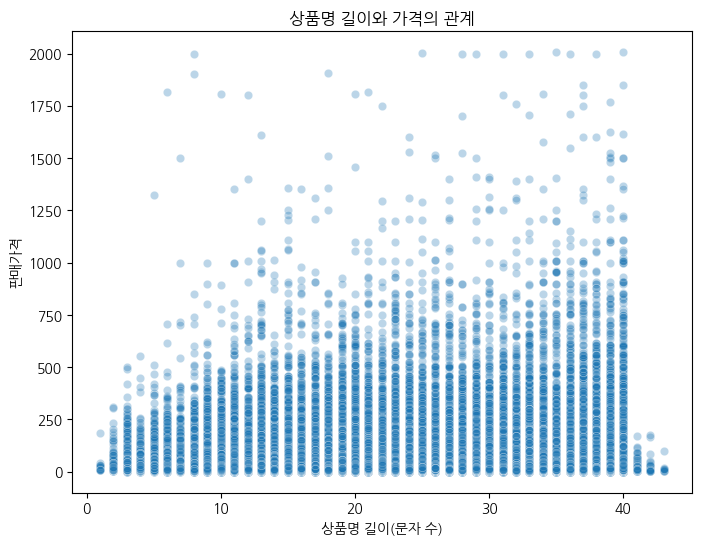

In [35]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    x=mercari_df['이름 글자 수'],
    y=mercari_df['가격'],
    alpha=0.3
)

plt.title('상품명 길이와 가격의 관계')
plt.xlabel('상품명 길이(문자 수)')
plt.ylabel('판매가격')
plt.show()

결론 : 상품명 길이가 길수록 가격이 조금씩 증가하는 경향이 보임 (그러나 설명/단어 수에 비해서는 상관성이 아주 약하고 제한적)

1. 이름 길이가 늘어날수록, 고가 상품 점들이 더 자주 등장함  
    + 이름 길이가 5~10정도일 때는 1000이상 가격대가 적게 나타났지만,
    + 20~40으로 갈수록 1000이상 고가 상품의 점들이 더 자주 등장함  <br><br>
즉, 상품명이 더 길어질수록, 고가 상품이 포함될 확률이 증가하는 경향이 있다.  
앞으로 나올 설명 길이나 단어 수에선 이런 현상이 없었기 때문에 상품명 길이는 상대적으로 조금 더 의미 있는 변수일 수 있다고 판단<br><br>
2. 하지만 전체적인 가격 분포는 여전히 낮은 가격대(0\~300)에 밀집  
    + 이름 길이가 5일때도 40일때도 대부분 0\~300<br><br>
즉, 대부분의 상품 가격은 이름 길이와 상관없이 낮음  
가격이 0~300인 상품이 전체 데이터의 중심을 차지하고 있어서 상관관계가 강하게 나타나지는 않음<br><br>
3. 산점도 전체 형태가 우상향 느낌을 아주 약하게 포함하고 있음  
    + 짧은 이름일수록 고가 가격이 적고 긴 이름일수록 고가 가격이 촘촘하고 다양함<br><br>
즉, 상품명이 길어질수록, 비싼 모델명/버전 정보/구성품 정보가 포함되는 경향이 있을 수 있음  
예) iPhone 12 Pro Max 256GB Box Included  
다만 여전히 전체 상품은 낮은 가격대에 집중되어서 상품명 길이 자체가 가격을 강력하게 설명하는 변수가 되긴 어려운 것으로 보임

### scatter(이름 단어 수 : 가격)

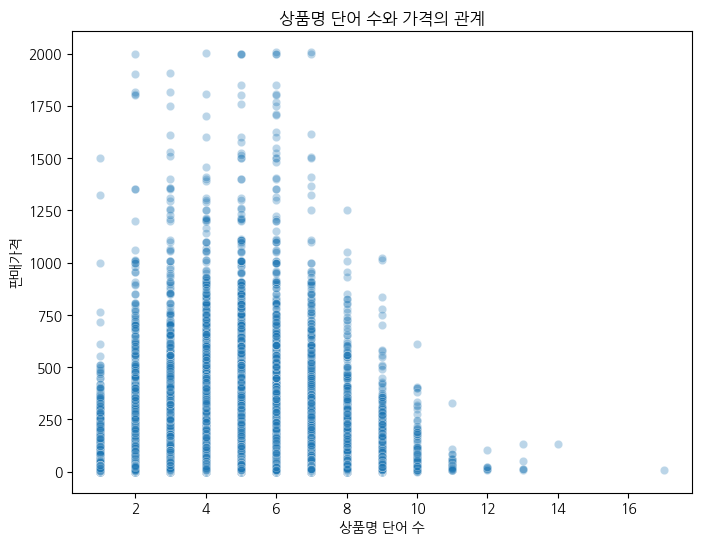

In [36]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    x=mercari_df['이름 단어 수'],
    y=mercari_df['가격'],
    alpha=0.3
)

plt.title('상품명 단어 수와 가격의 관계')
plt.xlabel('상품명 단어 수')
plt.ylabel('판매가격')
plt.show()


결론 : 상품명 단어 수는 가격과 거의 무관하고 단어 수가 많아질수록 가격은 오히려 낮아지는 경항을 보임

1. 단어 수가 많을수록 가격이 떨어짐
    + 그래프가 오른쪽으로 갈수록 고가 상품도 없고 대부분 낮은 가격대에 몰려 있음<br><br>
즉, 단어 수가 많아도 고가가 되는 게 아니라, 오히려 설명 같은 제목을 쓰는 저가 상품이 많다는 것으로 보임<br><br>
2. 고가 상품은 단어 수 3~6개 구간에 집중됨
    + 단어가 적당히 짧고 핵심적인 제목들이 고가에 많은 것으로 보임
    + 반대로 단어 수 10개 이상 상품 중 고가는 거의 없음<br><br>
##### 그러면 어째서 상품명이 길면 고가 가격이 있는데 단어가 많으면 저가 가격만 많을까?
고가 상품의 특징으론 모델명, 버전명, 구성품 정보 등이 있는데 이것들은 대부분 단어가 많진 않지만 단어가 길기 때문임

예) GeForce RTX 3060 Ti 8GB GDDR6, Air Jordan 1 Retro High OG Shadow, Alexander McQueen Oversized Sneaker

아마 저가 상품의 상품명이 긴 이유는 불필요한 말을 많이 했을 확률이 높은 것으로 보임

### box(이름 숫자 : 가격)

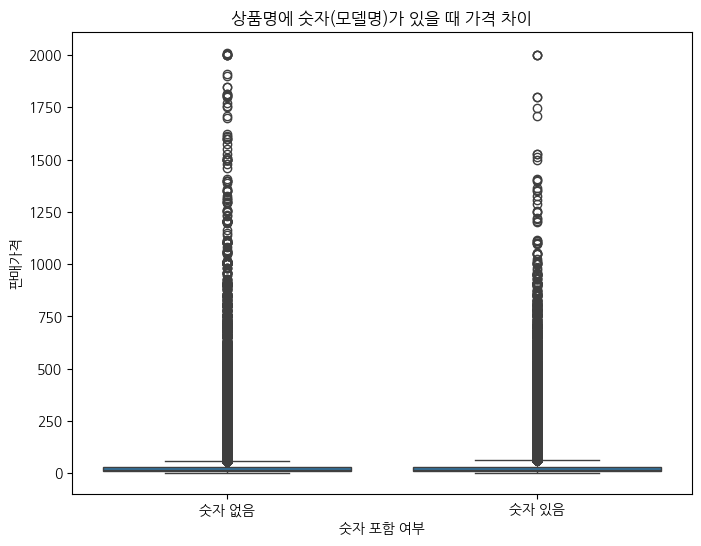

In [37]:
plt.figure(figsize=(8,6))

sns.boxplot(
    x=mercari_df['이름 숫자'],
    y=mercari_df['가격']
)

plt.xticks([0,1], ['숫자 없음', '숫자 있음'])

plt.title('상품명에 숫자(모델명)가 있을 때 가격 차이')
plt.xlabel('숫자 포함 여부')
plt.ylabel('판매가격')
plt.show()

결론 : 상품명에 숫자가 포함되었는지 여부만으로는 가격 차이가 거의 없음

다만, 두 그룹 모두 고가 상품이 존재하므로 숫자 포함 여부는 가격의 직접적인 결정 요소는 아니었음

1. 두 그룹의 중앙값이 거의 동일
    + 0과 1 모두 박스 위치가 거의 같아서 중앙값이 비슷하다고 보임<br><br>
즉, 숫자가 필요 없는 고가 카테고리(럭셔리 브랜드)와 숫자가 포함되는 고가 카테고리(전자제품) 둘 다 존재하기 때문에 숫자 포함 여부는 전체 가격과 거의 상관이 없게 되어버림

### box(이름 신품 키워드 : 가격)

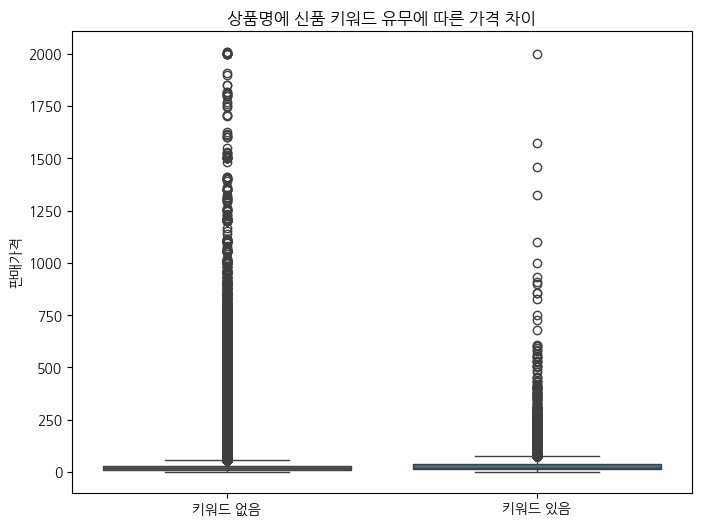

In [38]:
def contains_any(text, keywords):
    t = str(text).lower()
    return any(k.lower() in t for k in keywords)

keywords_new = ['新品', '未使用', '新品未使用', 'brand new', 'new, unopened', '未開封']
mercari_df['이름_신품키워드'] = mercari_df['이름'].apply(lambda x: int(contains_any(x, keywords_new)))

plt.figure(figsize=(8,6))

sns.boxplot(
    x=mercari_df['이름_신품키워드'],         # 0 = 없음, 1 = 있음
    y=mercari_df['가격']
)

plt.xticks([0,1], ['키워드 없음', '키워드 있음'])
plt.title('상품명에 신품 키워드 유무에 따른 가격 차이')
plt.xlabel('')
plt.ylabel('판매가격')
plt.show()

결론 : 키워드 유무가 가격에 큰 차이를 만들었다고 보기 어렵다.

1. 두 그룹의 중앙값이 거의 동일
    + 키워드 없음과 있음 모두 박스 위치가 거의 같아서 중앙값이 비슷하다고 보임 (평균적인 상품 가격은 차이가 없다)<br><br>
2. 그러나 극단적 고가 상품은 조금 차이가 있음
    + 키워드 있음 그룹이 더 극단적으로 높은 가격을 가진 제품들을 포함하고 있어서 일부에선 키워드가 영향을 줄 가능성은 있지만 가격 형성에서는 영향이 없다고 판단됨

## 상품 설명별

### scatter(설명 글자 수 : 가격)

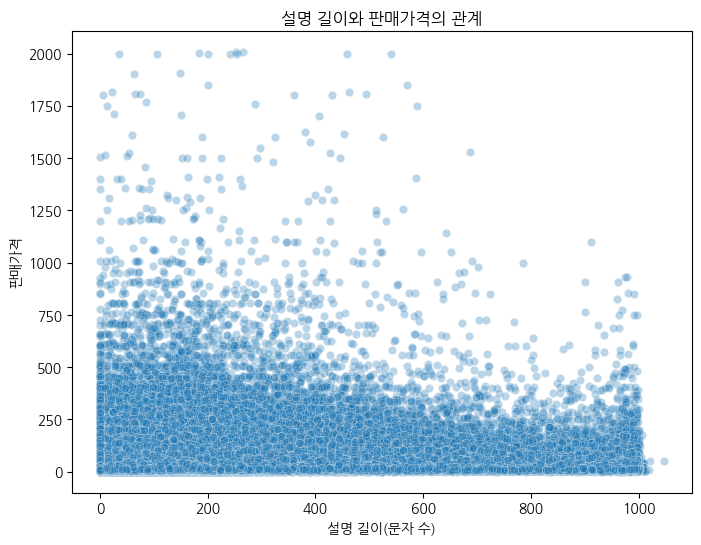

In [39]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    x=mercari_df['설명 글자 수'],
    y=mercari_df['가격'],
    alpha=0.3
)

plt.title('설명 길이와 판매가격의 관계')
plt.xlabel('설명 길이(문자 수)')
plt.ylabel('판매가격')
plt.show()

결론 : 상품 설명 길이가 길다고 해서 가격이 올라가는 건 아니다.

1. 그래프의 점들이 전체적으로 가로로 퍼져 있음
    + 설명 길이(가로축)가 50이든, 500이든, 1000이든 가격(세로축)과 거의 비슷한 범위에서 퍼져 있음<br><br>
즉, 설명이 길다고 해서 가격이 높아지는 비례는 아니었음<br><br>
2. 설명 길이가 짧은 구간(0~100)에서도 이미 가격이 높은 상품들이 존재함
    + 가격 1000-2000 같은 고가 상품들도 설명이 50-100글자 정도만 있어도 등장함<br><br>
즉, 고가 상품이 설명을 길게 쓴다는 증거가 없음<br><br>
3. 산점도에 전체적으로 패턴이 없음
    + 두 변수 간의 관계가 거의 없어 설명 길이는 가격을 예측하는 주요 요인이 아니라는 것을 확인
    + 메루카리의 가격은 설명 길이보다 브랜드, 제품 상태, 구성품 유무, 모델명, 카테고리 같은 정보에 더 민감하다고 볼 수 있음

### scatter(설명 단어 수 : 가격)

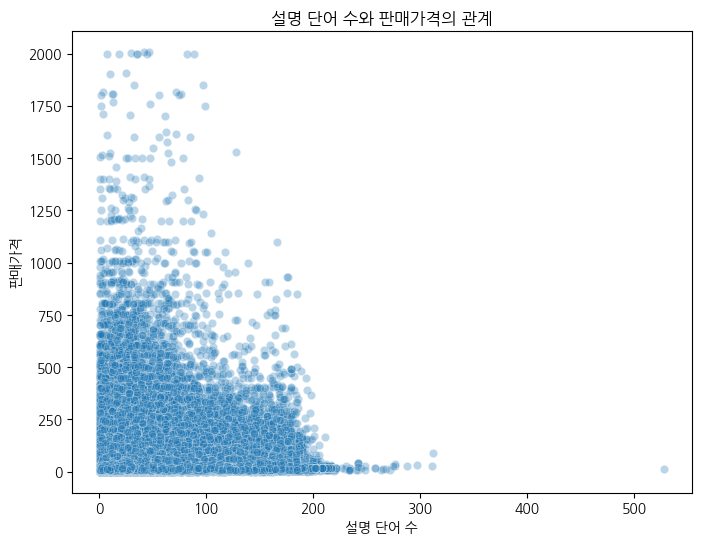

In [40]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=mercari_df['설명 단어 수'],
    y=mercari_df['가격'],
    alpha=0.3
)

plt.title('설명 단어 수와 판매가격의 관계')
plt.xlabel('설명 단어 수')
plt.ylabel('판매가격')
plt.show()

결론 : 설명 단어 수가 많아진다고 해서 가격이 올라가진 않음

1. 그래프 전체적으로 패턴이 없음
    + 단어 수가 0~50이든 100이든 200이든 가격대는 크게 달라지지 않고 거의 같은 범위에 몰려 있음 (상관 관계가 매우 약함)<br><br>
2. 낮은 가격대(0~300)의 상품은 어떤 상황에서도 많음
    + 단어 수가 적어도 많아도 대부분의 상품 가격이 0~300에 모여 있어서 가격을 결정하는 요인이 텍스트 정보량은 아닌 것으로 보임<br><br>
3. 오히려 단어 수가 많아질수록 저가 상품의 분포가 더 많아 보임
    + 많은 설명을 길게 쓰는 건 고가 상품이라서가 아니라 오히려 저가 상품일 가능성이 있음<br><br>
즉, 설명과 정보량이 길어도 좋은 정보는 아니고 판매자의 개인 말투에 영향 받을 수 있어서 핵심 요인은 아니라고 봐야 될 것 같음

### box(설명 레어 키워드 : 가격)

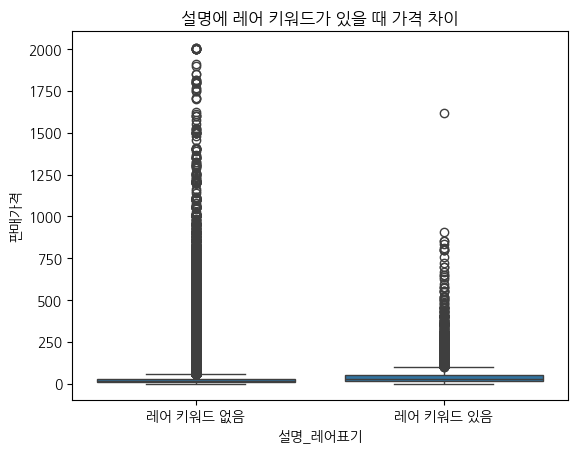

In [41]:
keywords_rare = ['限定', 'レア', 'rare', 'limited edition', 'コラボ']
mercari_df['설명_레어표기'] = mercari_df['제품 설명'].apply(lambda x: int(contains_any(x, keywords_rare)))

sns.boxplot(
    x=mercari_df['설명_레어표기'],
    y=mercari_df['가격']
)

plt.xticks([0,1], ['레어 키워드 없음', '레어 키워드 있음'])
plt.title('설명에 레어 키워드가 있을 때 가격 차이')
plt.ylabel('판매가격')
plt.show()

결론 : 키워드가 있다고 해서 평균 가격이 눈에 띄게 올라가진 않음

1. 두 그룹의 중앙값이 거의 동일
    + 키워드 없음과 있음 모두 박스 위치가 거의 같아서 중앙값이 비슷하다고 보임 (평균적인 상품 가격은 차이가 없다)<br><br>
2. 일부 극단적 고가 상품의 개수는 차이가 있음
    + 키워드 없음인 상품은 1500~2000 같은 고가 상품이 존재하고, 키워드 있음인 상품은 outlier 점들이 약간 더 많고 더 위까지 퍼져 있음<br><br>
즉, 전체 평균 가격은 동일하나, 일부 프리미엄 상품에서는 키워드가 가격을 올리는 요인으로 작용할 순 있을 것 같음
(신품, 레어, 박스같은 핵심 키워드가 포함된 상품이 평균적으로 더 높은 가격을 받는 것은 아니었다.)

## 가격별

###

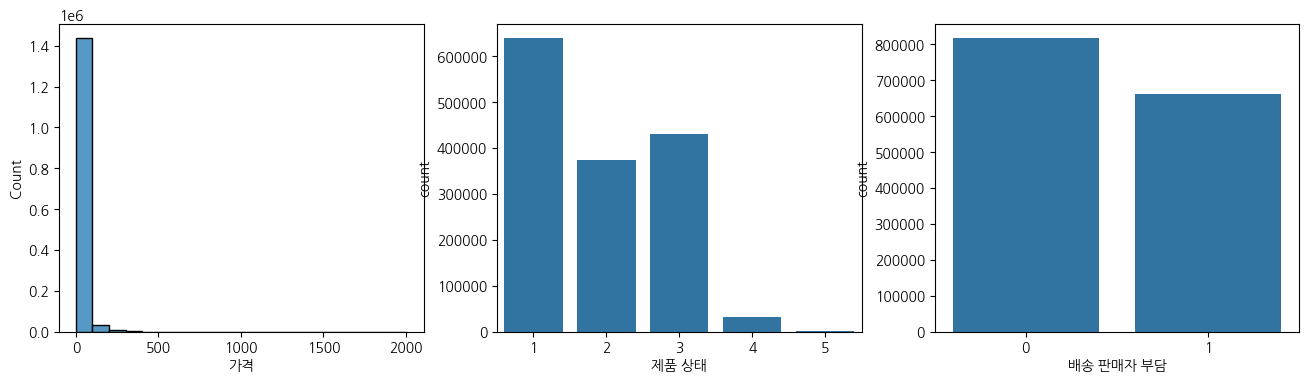

In [42]:
plt.figure(figsize=(16,4))
plt.subplot(131)
sns.histplot(mercari_df,x='가격',bins=20)
plt.subplot(132)
sns.countplot(mercari_df,x='제품 상태')
plt.subplot(133)
sns.countplot(mercari_df,x='배송 판매자 부담')
plt.show()

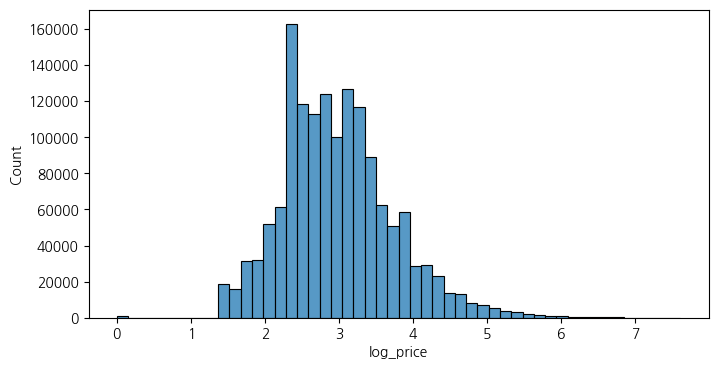

In [43]:
mercari_df['log_price'] = np.log1p(mercari_df['가격'])
plt.figure(figsize=(8, 4))
sns.histplot(mercari_df['log_price'], bins=50)
plt.show()

결론 : 가격은 극단적 고가 상품 때문에 심하게 왜곡되어 있으며, log 변환을 통해 실제 ‘전형적인 상품 가격대’를 더 정확하게 해석할 수 있음

1. 원래 가격 분포는 극단적 오른쪽 꼬리(long-tail) 형태
  + 대부분 상품 가격이 0~50달러 근처에 몰려 있음
  + 소수의 고가 상품(수백~수천 달러)이 분포를 한쪽으로 길게 끌고 감
  + 이 극단값 때문에 평균 가격은 실제 중앙값보다 훨씬 더 높게 왜곡됨(평균이 데이터를 대표하지 못함)<br><br>
→ 즉, 원래 가격(raw price)은 분포 왜도가 심해 분석에 부적합함

2. log1p 변환 후 가격 분포는 정규분포에 가까워짐
  + 로그 변환을 적용하면 극단적 고가 상품의 영향이 크게 줄어듦
  + 전체 분포가 종 모양으로 정돈되어 전형적인 가격 범위를 더 잘 드러냄
  + log_price는 평균, 중앙값 모두 데이터의 일반적인 패턴을 더 잘 표현함<br><br>
→ log_price는 모델 입력 또는 통계적 해석에 훨씬 적합한 변수

## 브랜드별

### count(브랜드)

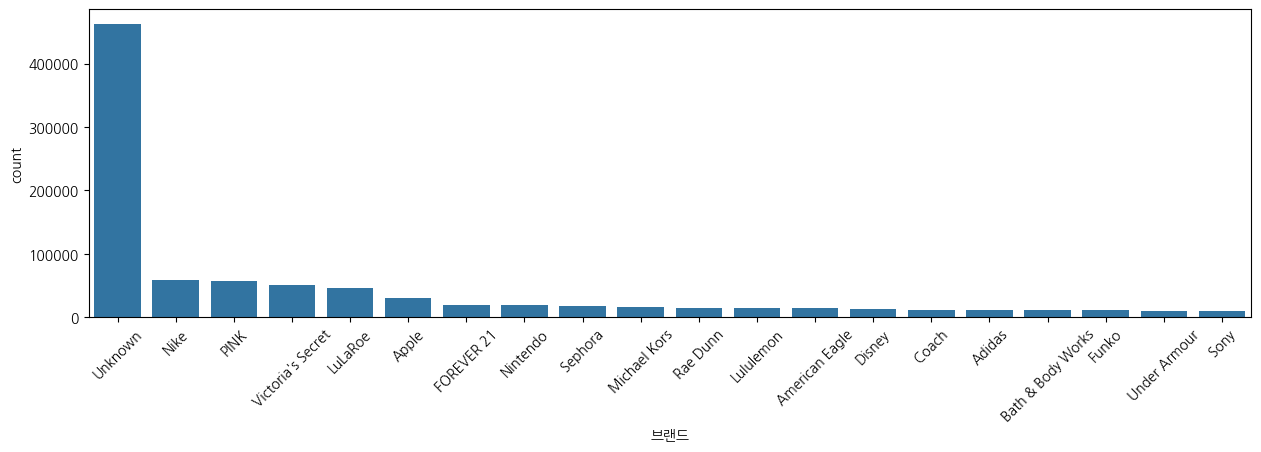

In [44]:
plt.figure(figsize=(15,4))
a=mercari_df['브랜드'].value_counts().head(20).reset_index()
sns.barplot(x=a['브랜드'],y=a['count'])
plt.xticks(rotation=45)
plt.show()

### bar(브랜드 : 가격 : 브랜드 결측)

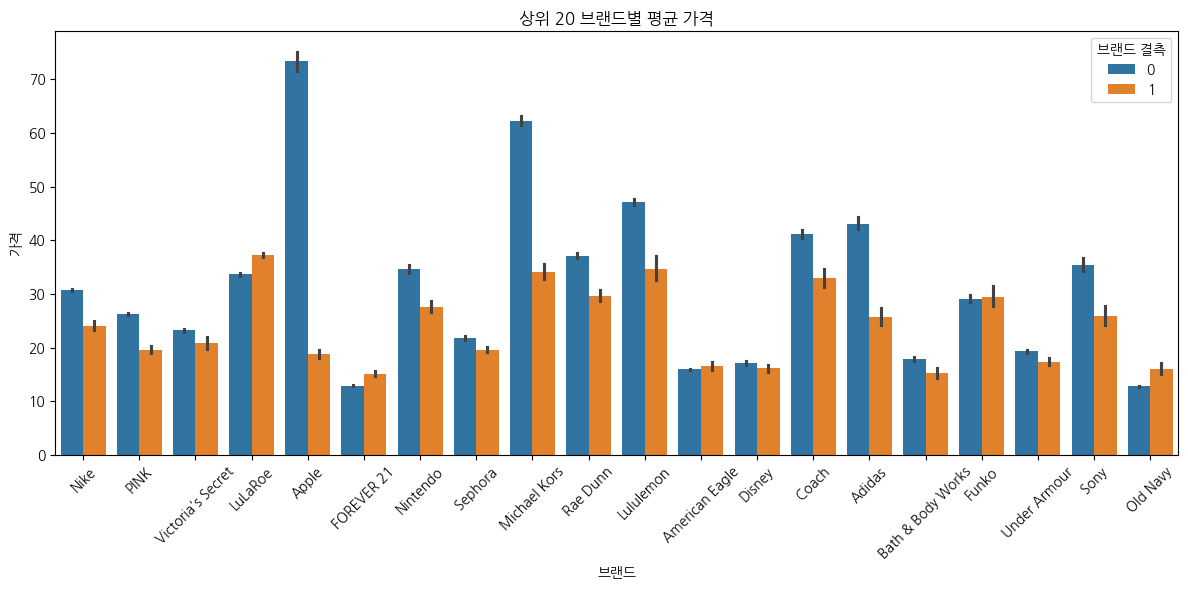

In [45]:
# 상위 20개 브랜드 이름만 뽑기
top20 = (mercari_df['브랜드'].value_counts().head(21).index)[1:]

df_plot = mercari_df[mercari_df['브랜드'].isin(top20)].copy()

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_plot,
    x='브랜드',
    y='가격',
    hue='브랜드 결측',
    estimator=np.mean,  # 브랜드별 평균 가격
    order=top20         # x축 브랜드 순서를 top20 순서대로 고정
)
plt.title('상위 20 브랜드별 평균 가격')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### count(브랜드, 브랜드 결측)

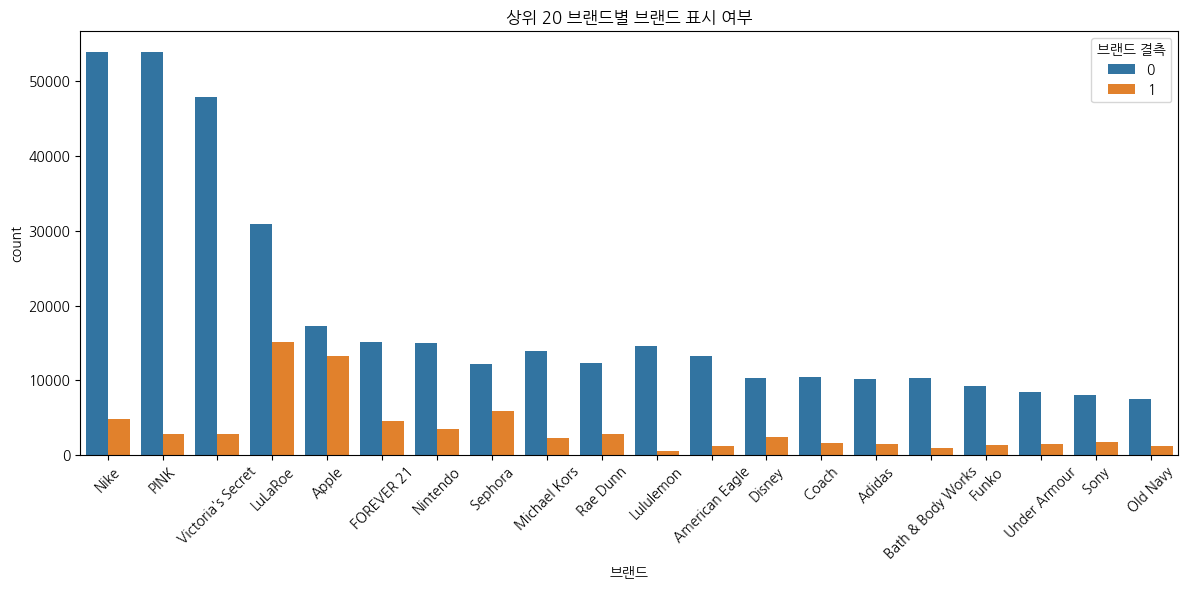

In [46]:
plt.figure(figsize=(12, 6))

sns.countplot(
    data=df_plot,
    x='브랜드',
    hue='브랜드 결측',
    order=top20         # x축 브랜드 순서를 top20 순서대로 고정
)
plt.title('상위 20 브랜드별 브랜드 표시 여부')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 대분류 카테고리별

### count(대분류)

대분류
Women                     45.01
Beauty                    14.07
Kids                      11.63
Electronics                8.31
Men                        6.35
Home                        4.6
Vintage & Collectibles     3.15
Other                      3.08
Handmade                   2.09
Sports & Outdoors          1.72
Name: proportion, dtype: Float64


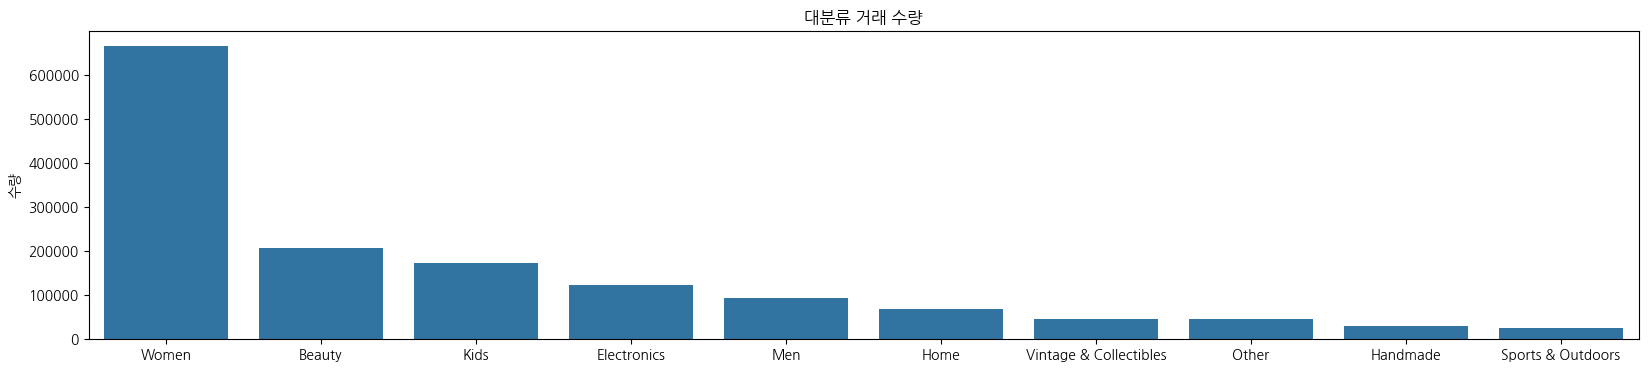

In [47]:
print(round(mercari_df['대분류'].value_counts(normalize=True)*100,2).sort_values(ascending=False))
plt.figure(figsize=(20,4))
sns.countplot(data=mercari_df, x='대분류',order=mercari_df['대분류'].value_counts().index)
plt.title('대분류 카테고리')
plt.xlabel('')
plt.ylabel('수량')
plt.title('대분류 거래 수량')
plt.show()

### box(대분류 : 가격)

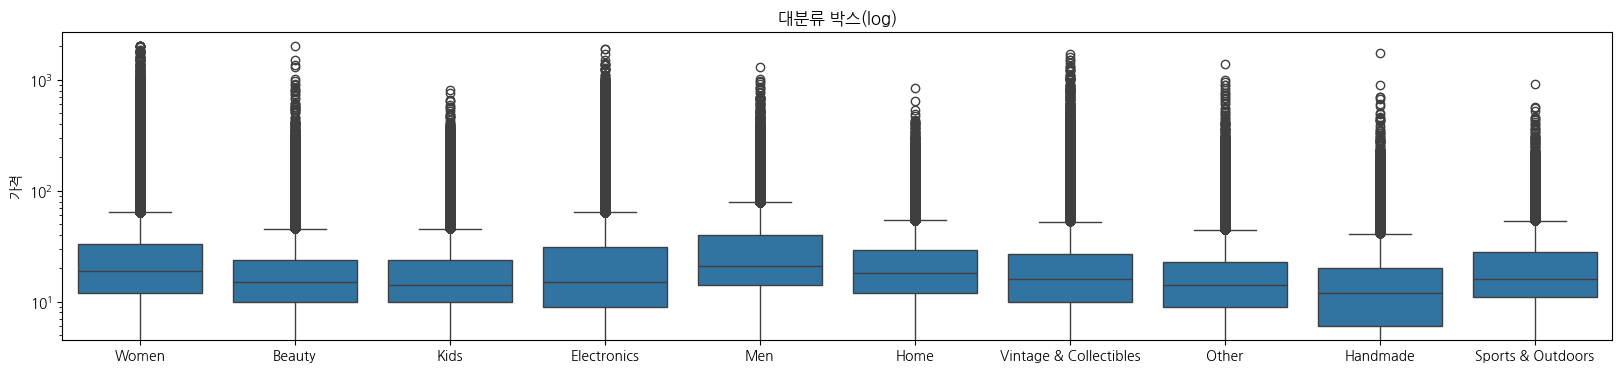

In [48]:
plt.figure(figsize=(20,4))
sns.boxplot(mercari_df, x='대분류', y='가격',order=mercari_df['대분류'].value_counts().index)
plt.yscale('log')
plt.xlabel('')
plt.title('대분류 박스(log)')
plt.show()

### bar(대분류 : 가격)

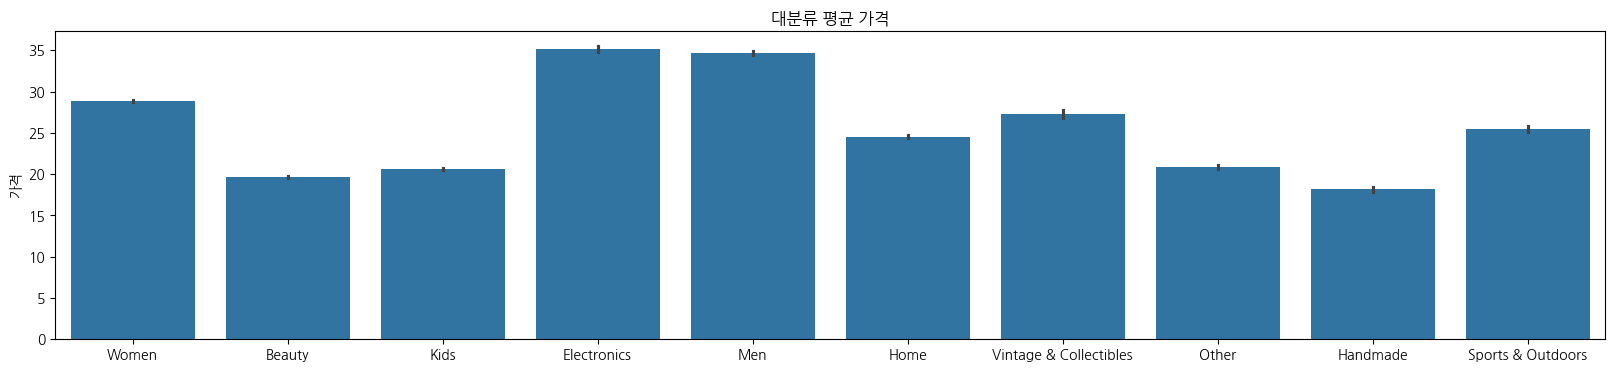

In [49]:
plt.figure(figsize=(20,4))
sns.barplot(mercari_df, x='대분류', y='가격',order=mercari_df['대분류'].value_counts().index)
plt.title('대분류 평균 가격')
plt.xlabel('')
plt.show()

### corr(대분류 : 피쳐)

In [50]:
corr_df = mercari_df.groupby('대분류').corr(numeric_only=True).unstack().reindex(['Women', 'Beauty', 'Kids', 'Electronics', 'Men', 'Home','Vintage & Collectibles', 'Other', 'Handmade', 'Sports & Outdoors'])
corr_df.iloc[:,0:12]['가격']

,가격,제품 상태,배송 판매자 부담,카테고리 결측,브랜드 결측,설명 결측,이름 글자 수,이름 단어 수,이름 특수기호,이름 특수기호 수,이름 숫자,이름 숫자 수
대분류,,,,,,,,,,,,
Women,1.0,-0.069643,-0.055053,-0.003079,-0.090068,-0.033931,0.087464,0.074387,0.014593,0.034715,0.030999,0.038668
Beauty,1.0,-0.014361,-0.151767,0.003588,-0.033442,-0.008947,-0.002494,0.004663,0.021905,0.031681,0.015329,0.033942
Kids,1.0,-0.048369,-0.134073,0.005234,-0.077775,-0.029552,0.032070,0.026202,0.013200,0.031759,0.005183,0.037464
Electronics,1.0,0.120542,-0.162674,0.002582,-0.253161,-0.058979,-0.078998,-0.040776,0.077412,0.121983,0.104052,0.169951
Men,1.0,-0.115006,-0.047635,0.003625,-0.131239,-0.035572,-0.003716,0.041675,0.107670,0.167356,0.247698,0.231890
Home,1.0,-0.101502,-0.173526,-0.000901,-0.179512,-0.015815,0.052934,0.073937,0.040685,0.046852,0.029071,0.034783
Vintage & Collectibles,1.0,0.043267,-0.102783,-0.001738,-0.087350,-0.032142,0.014908,0.011116,-0.000457,-0.002715,0.002557,-0.004545
Other,1.0,0.021073,-0.140058,0.012397,-0.052470,-0.024420,-0.013308,-0.032779,0.004915,-0.006959,0.000937,-0.013481
Handmade,1.0,0.126608,-0.213336,-0.006929,0.000785,-0.023422,0.003591,0.003768,-0.002288,0.032541,-0.003368,0.052148


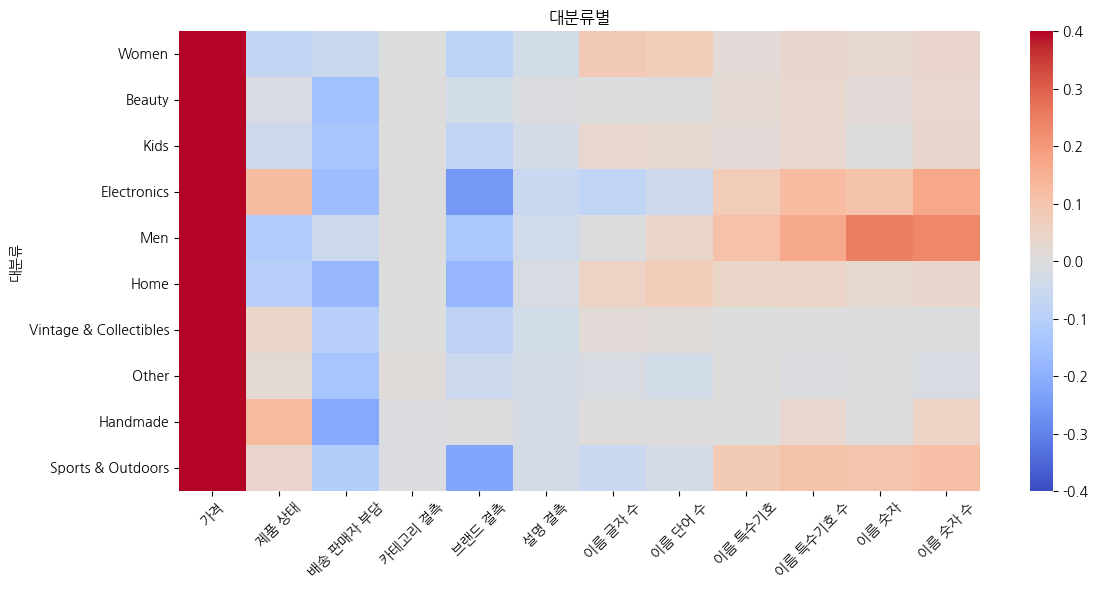

In [51]:
a = corr_df.iloc[:,0:12]['가격'].reset_index()
heat = a.set_index('대분류')

plt.figure(figsize=(12,6))
sns.heatmap(heat, annot=False, cmap='coolwarm', center=0, vmin=-0.4, vmax=0.4)
plt.title("대분류별")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 상관관계 가이드라인
 + |r| < 0.1
상관 없음(Negligible)
 + 0.1 ≤ |r| < 0.3
매우 약한 상관(Very Weak)
 + 0.3 ≤ |r| < 0.5
약한 상관(Weak)
 + 0.5 ≤ |r| < 0.7
중간 정도의 상관(Moderate)
 + 0.7 ≤ |r| < 0.9
강한 상관(Strong)
 + |r| ≥ 0.9
매우 강한 상관(Very Strong)

## 중분류 카테고리별

### count(중분류 : 대분류)

In [52]:
pd.set_option('display.max_rows',138)
a=mercari_df.groupby(['대분류','중분류'])['가격'].count().reset_index(name='count').sort_values('count',ascending=False).head(20)
a

,대분류,중분류,count
3,Beauty,Makeup,124704
121,Women,Athletic Apparel,123541
134,Women,Tops & Blouses,107073
129,Women,Shoes,77724
73,Kids,Toys,57770
125,Women,Jewelry,56899
9,Electronics,Cell Phones & Accessories,53300
137,Women,Women's Handbags,45934
123,Women,Dresses,45864
136,Women,Women's Accessories,42389


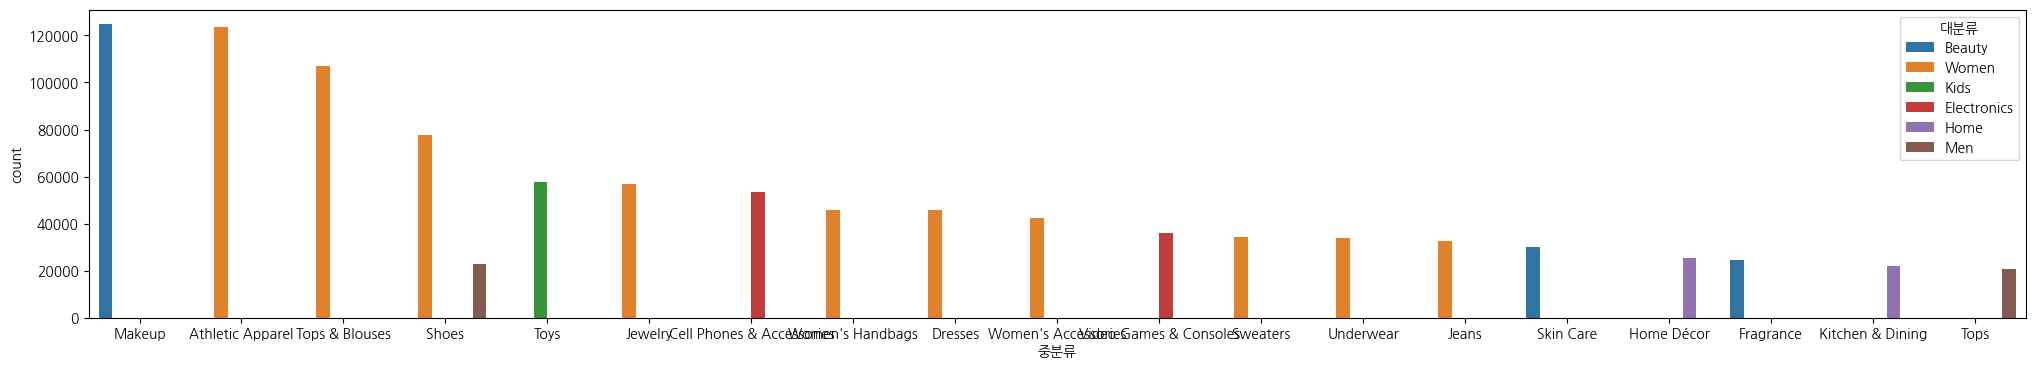

In [53]:
plt.figure(figsize=(25,4))
sns.barplot(a, x='중분류',y='count', hue='대분류')
plt.show()

In [54]:
corr_dict = {}

# 대분류 순서를 유지한 채로 생성
cate2_list = mercari_df[['대분류','중분류']].sort_values('대분류')['중분류'].drop_duplicates()
for i in cate2_list:
    subset = mercari_df[mercari_df['중분류'] == i]
    corr = subset.corr(numeric_only=True)['가격']   # 가격과의 상관만 추출
    corr_dict[i] = corr

corr_df = pd.DataFrame(corr_dict)
corr_df_T = pd.DataFrame(corr_dict).T

### corr(중분류 : 피쳐)

In [55]:
corr_df_T.head()

,가격,제품 상태,배송 판매자 부담,카테고리 결측,브랜드 결측,설명 결측,이름 글자 수,이름 단어 수,이름 특수기호,이름 특수기호 수,...,설명 글자 수,설명 단어 수,설명 가격,설명 특수기호,설명 특수기호 수,설명 숫자,설명 숫자 수,이름_신품키워드,설명_레어표기,log_price
Makeup,1.0,-0.019562,-0.138360,0.004817,-0.081327,0.000172,-0.007004,-0.006345,0.001373,0.006281,...,0.016727,0.013728,0.014667,0.008938,0.017514,0.002082,0.038522,-0.001014,0.099156,0.715873
Tools & Accessories,1.0,0.057971,-0.212873,-0.006089,-0.007023,-0.045233,-0.001214,0.016917,-0.017559,0.003300,...,0.039914,0.040555,0.108239,0.062682,0.044277,0.005183,0.077713,0.021079,0.104301,0.827458
Bath & Body,1.0,-0.029067,-0.211745,0.007152,0.016250,0.004610,-0.021920,-0.002272,-0.006141,-0.020168,...,0.013475,0.018663,-0.045850,0.039272,0.054868,-0.004528,0.144463,-0.000378,0.014348,0.832462
Hair Care,1.0,-0.077020,-0.162090,0.033131,0.066351,-0.008733,0.019593,0.026621,0.044451,0.088941,...,0.067516,0.067929,0.083221,0.010865,0.107773,-0.014555,0.160729,0.010975,0.033599,0.883941
Skin Care,1.0,-0.022059,-0.137294,0.000851,0.060576,-0.023230,-0.010156,-0.019427,0.035352,0.023016,...,-0.004204,-0.005850,0.085808,0.030374,0.021664,0.001716,0.057927,0.003243,0.008422,0.780591


In [56]:
corr_df.columns

Index(['Makeup', 'Tools & Accessories', 'Bath & Body', 'Hair Care',
       'Skin Care', 'Fragrance', 'Other', 'Media', 'Cell Phones & Accessories',
       'Video Games & Consoles',
       ...
       'Home Decor', 'Paper Ephemera', 'Underwear', 'Tops & Blouses', 'Skirts',
       'Women's Handbags', 'Women's Accessories', 'Dresses', 'Maternity',
       'Suits & Blazers'],
      dtype='object', length=113)

### 상관관계 결과

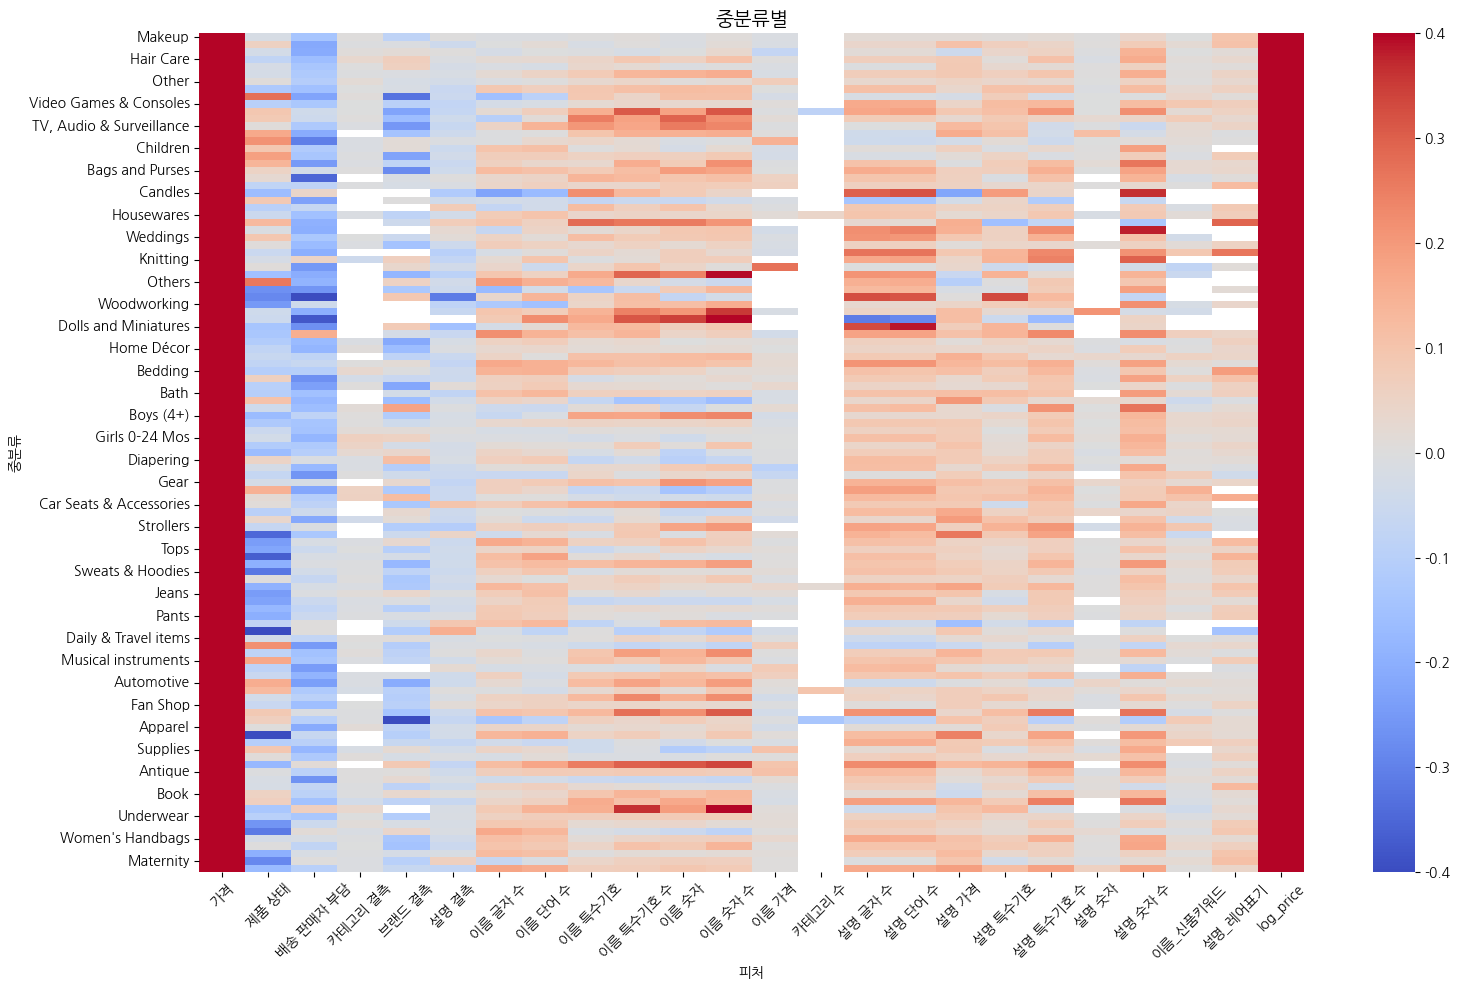

In [57]:
plt.figure(figsize=(16, 10))
sns.heatmap(
    corr_df_T, 
    cmap='coolwarm', 
    center=0,
    vmin=-0.4, vmax=0.4,    # 색 대비 강조 → 약한 상관계수도 한눈에 확인 가능
    annot=False
)
plt.title("중분류별", fontsize=14)
plt.xlabel("피처")
plt.ylabel("중분류")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
corr_dict={}
for i,j in enumerate(['제품 상태', '배송 판매자 부담', '카테고리 결측', '브랜드 결측', '설명 결측', '이름 글자 수',
       '이름 단어 수', '이름 특수기호', '이름 특수기호 수', '이름 숫자', '이름 숫자 수', '이름 가격',
       '카테고리 수', '설명 글자 수', '설명 단어 수', '설명 가격', '설명 특수기호', '설명 특수기호 수',
       '설명 숫자', '설명 숫자 수']):
    print(f'\n속성 : {j}')
    print(corr_df_T[corr_df_T[j].apply(abs)>=0.2][j].sort_values(ascending=False))
    corr_dict[j] = corr_df_T[j].sort_values(ascending=False)


속성 : 제품 상태
Cell Phones & Accessories    0.274144
Others                       0.260771
Office supplies              0.218493
Paper Goods                  0.215481
Pants                       -0.201049
Tops                        -0.222223
Shorts                      -0.229157
Athletic Apparel            -0.243710
Jeans                       -0.246681
Woodworking                 -0.252553
Tops & Blouses              -0.259956
Books and Zines             -0.271271
Ceramics and Pottery        -0.287048
Maternity                   -0.287494
Skirts                      -0.314138
Sweats & Hoodies            -0.321188
Potty Training              -0.348637
Sweaters                    -0.365922
Blazers & Sport Coats       -0.425975
Footwear                    -0.453183
Name: 제품 상태, dtype: float64

속성 : 배송 판매자 부담
Patterns                    -0.200738
Glass                       -0.201675
Crochet                     -0.201971
Pets                        -0.205868
Car Audio, Video & GPS      -0.2

#### 가설 1 시각화 : 제품 컨디션에 따른 상관관계

Text(0, 0.5, '중분류')

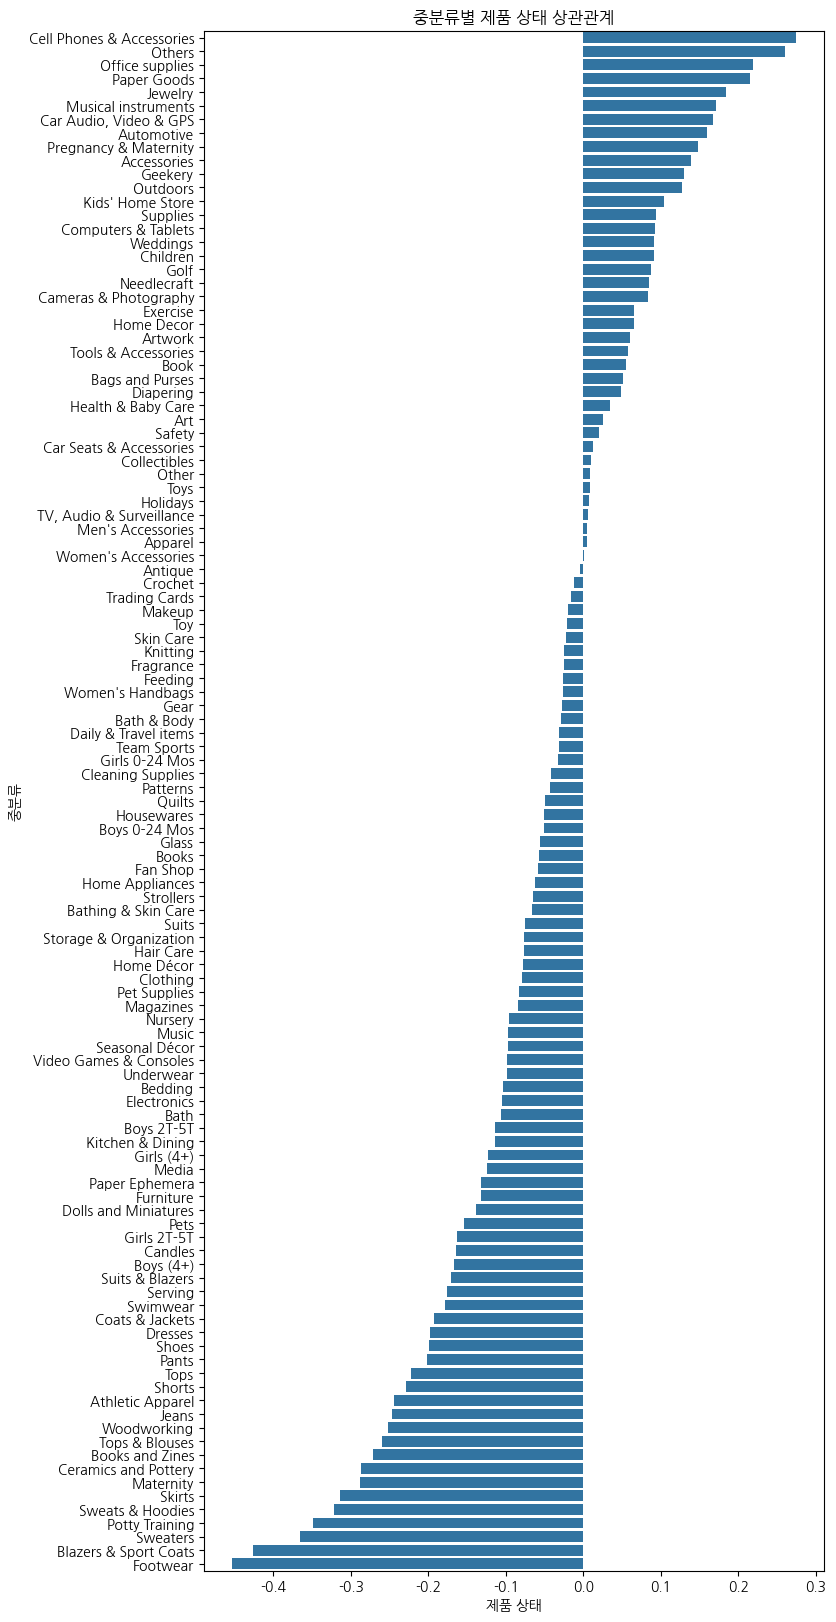

In [59]:
cate2_corr_cond=pd.DataFrame(corr_dict['제품 상태'])
cate2_corr_brand=pd.DataFrame(corr_dict['브랜드 결측'])
cate2_corr_desc=pd.DataFrame(corr_dict['설명 글자 수'])
plt.figure(figsize=(8,20))
sns.barplot(cate2_corr_cond,x='제품 상태',y=cate2_corr_cond['제품 상태'].index)
plt.title('중분류별 제품 상태 상관관계')
plt.ylabel('중분류')

#### 가설 2 시각화 : 설명 길이에 대한 상관관계

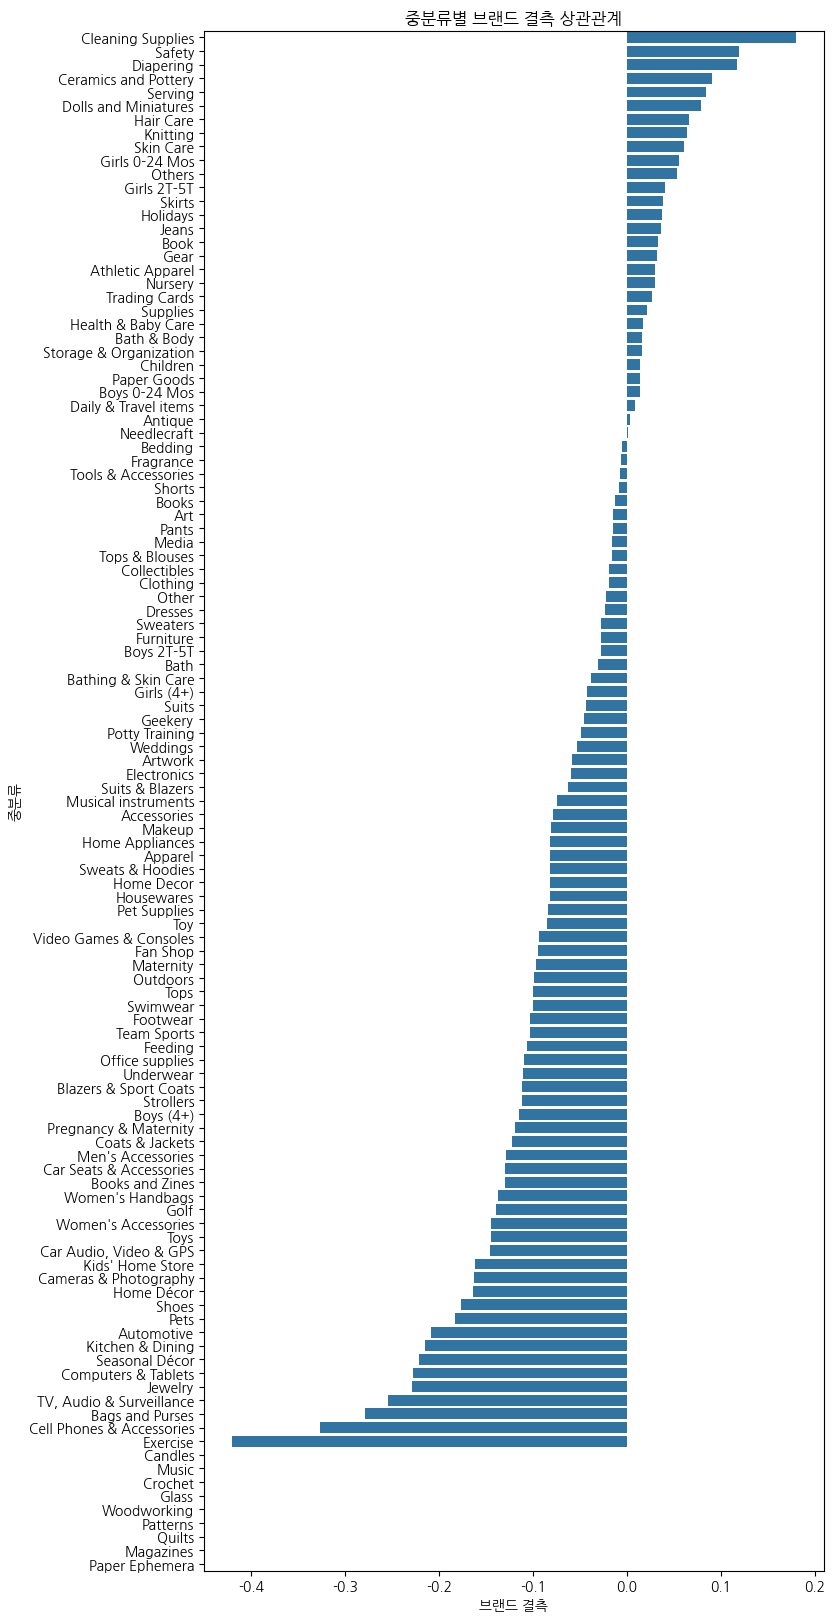

In [60]:
plt.figure(figsize=(8,20))
sns.barplot(cate2_corr_brand,x='브랜드 결측',y=cate2_corr_brand['브랜드 결측'].index)
plt.title('중분류별 브랜드 결측 상관관계')
plt.ylabel('중분류')
plt.show()

#### 가설 3 시각화 : 배송비 주체 상관관계

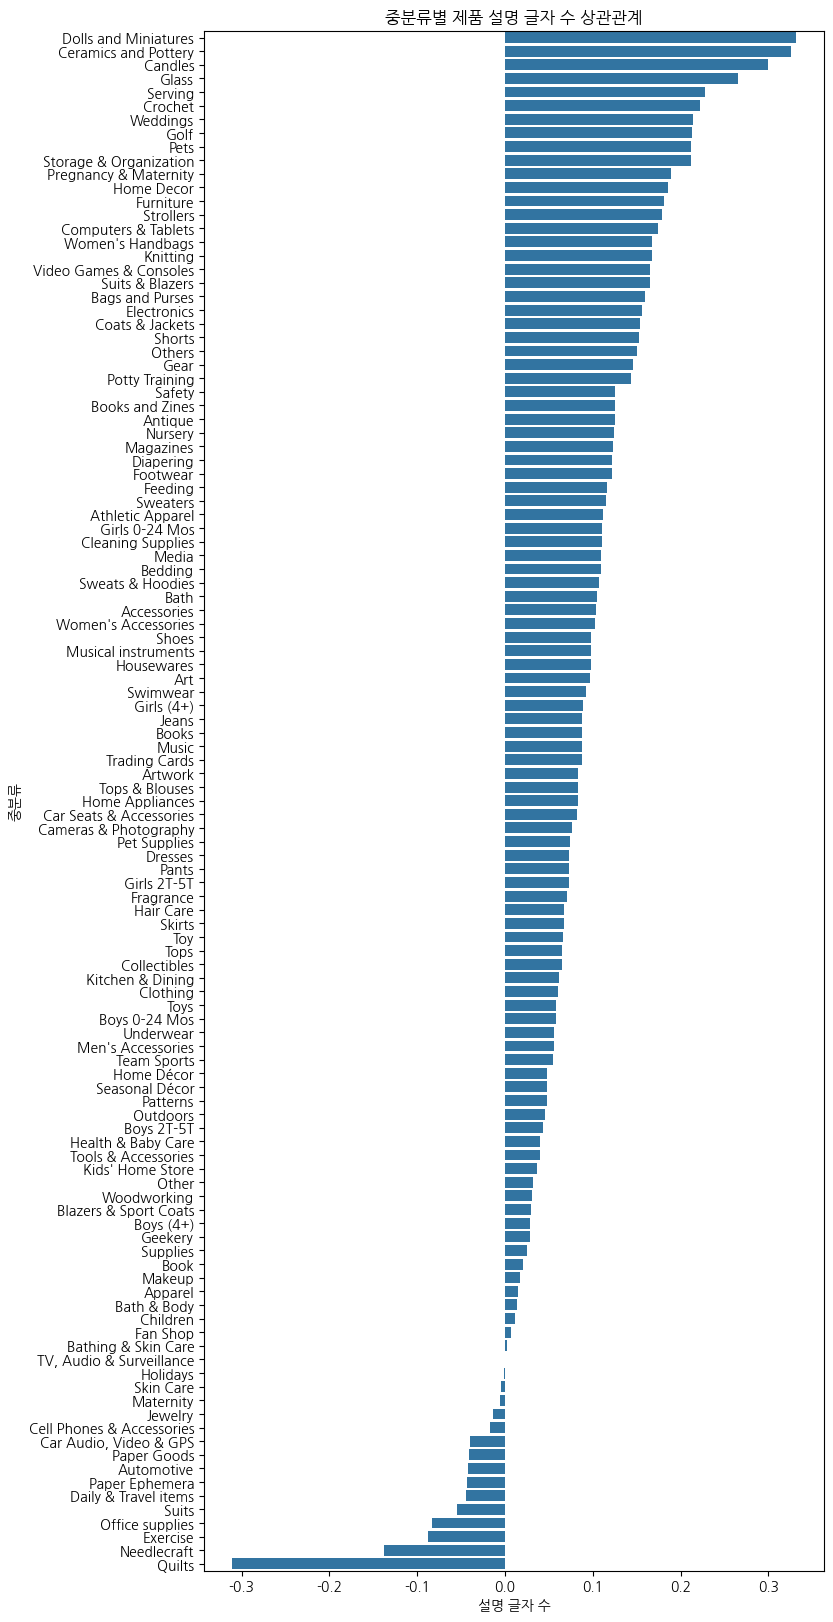

In [61]:
plt.figure(figsize=(8,20))
sns.barplot(cate2_corr_desc,x='설명 글자 수',y=cate2_corr_desc['설명 글자 수'].index)
plt.title('중분류별 제품 설명 글자 수 상관관계')
plt.ylabel('중분류')
plt.show()

# 가격 예측 모델링

### 전처리

In [62]:
mercari_df=mercari_df[['가격','이름','제품 상태','브랜드','배송 판매자 부담','제품 설명','카테고리 결측','브랜드 결측','설명 결측','이름 글자 수','이름 단어 수','이름 특수기호','이름 특수기호 수','이름 숫자','이름 숫자 수','이름 가격','대분류','중분류','소분류','카테고리 수','설명 글자 수','설명 단어 수','설명 가격','설명 특수기호','설명 특수기호 수','설명 숫자','설명 숫자 수']]
mercari_df.columns=['price','name', 'item_condition_id', 'brand_name', 'shipping','item_description', 'no_cate', 'no_brand', 'no_desc','name_len','name_words','name_special','name_special_count', 'name_digit', 'name_digit_count', 'name_rm','cate1', 'cate2', 'cate3', 'category_count','desc_len', 'desc_words', 'desc_rm', 'desc_special','desc_special_count', 'desc_digit', 'desc_digit_count']

In [63]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower().strip()

In [64]:
mercari_df['clean_name'] = mercari_df['name'].astype(str).apply(clean_text)
mercari_df['clean_desc'] = mercari_df['item_description'].astype(str).apply(clean_text)
mercari_df['full_text'] = mercari_df['clean_name'] + " " + mercari_df['clean_desc'].astype(str)
mercari_df['clean_brand'] = mercari_df['brand_name'].fillna('').astype(str)

In [65]:
mercari_df['clean_brand'] = (
    mercari_df['clean_brand']
    .fillna('')        # NaN -> ''
    .astype(str)       # float, None 등 다 str로
    .str.lower()
)

mercari_df['clean_name'] = (
    mercari_df['clean_name']
    .fillna('')
    .astype(str)
    .str.lower()
)

mercari_df['clean_desc'] = (
    mercari_df['clean_desc']
    .fillna('')
    .astype(str)
    .str.lower()
)

In [66]:
def has_brand_in_name(row):
    brand = row['clean_brand']
    name = row['clean_name']
    
    # 브랜드가 있고(빈칸 아니고), 텍스트에 포함되어 있다면
    if brand and brand in name:
        # 브랜드 이름을 공백으로 대체
        return True
    return False

def has_brand_in_desc(row):
    brand = row['clean_brand']
    desc = row['clean_desc']
    
    # 브랜드가 있고(빈칸 아니고), 텍스트에 포함되어 있다면
    if brand and brand in desc:
        # 브랜드 이름을 공백으로 대체
        return True
    return False

In [67]:
mercari_df['has_brand_in_name'] = mercari_df.apply(has_brand_in_name, axis=1)
mercari_df['has_brand_in_desc'] = mercari_df.apply(has_brand_in_desc, axis=1)

In [68]:
def remove_brand_from_name(row):
    brand = row['clean_brand']
    name = row['clean_name']
    
    # 브랜드가 있고(빈칸 아니고), 텍스트에 포함되어 있다면
    if brand and brand in name:
        # 브랜드 이름을 공백으로 대체
        return name.replace(brand, '')
    return name

def remove_brand_from_desc(row):
    brand = row['clean_brand']
    desc = row['clean_desc']
    
    # 브랜드가 있고(빈칸 아니고), 텍스트에 포함되어 있다면
    if brand and brand in desc:
        # 브랜드 이름을 공백으로 대체
        return desc.replace(brand, '')
    return desc

def remove_categories_name(df):
    print("1. 카테고리 및 텍스트 데이터 준비 중...")
    # 전처리를 위해 모두 소문자로 변환하고 문자열로 확보
    # (이미 clean_text_no_brand는 소문자 처리 되어 있다고 가정)
    name = df['clean_name_no_brand'].astype(str).tolist()
    
    # 카테고리 컬럼들도 결측치 처리 후 리스트로 변환
    c1 = df['cate1'].astype(str).str.lower().tolist()
    c2 = df['cate2'].astype(str).str.lower().tolist()
    c3 = df['cate3'].astype(str).str.lower().tolist()
    
    result_texts = []
    has_cat_flags = []
    
    print("2. 행별 카테고리 이름 제거 시작 (고속 연산)...")
    # zip으로 4개의 리스트를 묶어서 한 번에 돕니다 (속도 핵심)
    # t: 텍스트, c1/c2/c3: 대/중/소분류 이름
    for t, cat1, cat2, cat3 in zip(name, c1, c2, c3):
        
        # 카테고리 이름들을 리스트로 묶음 (빈칸 제외)
        cats_to_remove = [cat for cat in [cat1, cat2, cat3] if cat]
        
        # [핵심 로직] 텍스트에서 해당 카테고리 단어 제거
        temp_text = t
        found_flag = 0
        
        for cat in cats_to_remove:
            # 단순 replace는 'women'을 지울 때 'women's'가 깨질 수 있음
            # 하지만 속도를 위해 일단 replace를 쓰고, 정교하게 하려면 regex 사용
            # 여기서는 replace로 충분 (이미 특수문자 제거된 상태이므로)
            found_flag = 1
            temp_text = temp_text.replace(cat, '')
            
        result_texts.append(temp_text)
        has_cat_flags.append(found_flag)
        
    return result_texts, has_cat_flags

def remove_categories_desc(df):
    print("1. 카테고리 및 텍스트 데이터 준비 중...")
    # 전처리를 위해 모두 소문자로 변환하고 문자열로 확보
    # (이미 clean_text_no_brand는 소문자 처리 되어 있다고 가정)
    desc = df['clean_desc_no_brand'].astype(str).tolist()
    
    # 카테고리 컬럼들도 결측치 처리 후 리스트로 변환
    c1 = df['cate1'].astype(str).str.lower().tolist()
    c2 = df['cate2'].astype(str).str.lower().tolist()
    c3 = df['cate3'].astype(str).str.lower().tolist()
    
    result_texts = []
    has_cat_flags = []
    
    print("2. 행별 카테고리 이름 제거 시작 (고속 연산)...")
    # zip으로 4개의 리스트를 묶어서 한 번에 돕니다 (속도 핵심)
    # t: 텍스트, c1/c2/c3: 대/중/소분류 이름
    for t, cat1, cat2, cat3 in zip(desc, c1, c2, c3):
        
        # 카테고리 이름들을 리스트로 묶음 (빈칸 제외)
        cats_to_remove = [cat for cat in [cat1, cat2, cat3] if cat]
        
        # [핵심 로직] 텍스트에서 해당 카테고리 단어 제거
        temp_text = t
        found_flag = 0
        
        for cat in cats_to_remove:
            # 단순 replace는 'women'을 지울 때 'women's'가 깨질 수 있음
            # 하지만 속도를 위해 일단 replace를 쓰고, 정교하게 하려면 regex 사용
            # 여기서는 replace로 충분 (이미 특수문자 제거된 상태이므로)
            temp_text = temp_text.replace(cat, '')
            
        result_texts.append(temp_text)
        has_cat_flags.append(found_flag)
        
    return result_texts, has_cat_flags

In [69]:
mercari_df['clean_name_no_brand'] = mercari_df.apply(remove_brand_from_name, axis=1)
a,b=remove_categories_name(mercari_df)
mercari_df['clean_name_no_brand'] = a
mercari_df['has_category_in_name'] = b

1. 카테고리 및 텍스트 데이터 준비 중...
2. 행별 카테고리 이름 제거 시작 (고속 연산)...


In [70]:
mercari_df['clean_desc_no_brand'] = mercari_df.apply(remove_brand_from_desc, axis=1)
a,b=remove_categories_desc(mercari_df)
mercari_df['clean_desc_no_brand'] = a
mercari_df['has_category_in_desc'] = b

1. 카테고리 및 텍스트 데이터 준비 중...
2. 행별 카테고리 이름 제거 시작 (고속 연산)...


In [71]:
mercari_df.columns

Index(['price', 'name', 'item_condition_id', 'brand_name', 'shipping',
       'item_description', 'no_cate', 'no_brand', 'no_desc', 'name_len',
       'name_words', 'name_special', 'name_special_count', 'name_digit',
       'name_digit_count', 'name_rm', 'cate1', 'cate2', 'cate3',
       'category_count', 'desc_len', 'desc_words', 'desc_rm', 'desc_special',
       'desc_special_count', 'desc_digit', 'desc_digit_count', 'clean_name',
       'clean_desc', 'full_text', 'clean_brand', 'has_brand_in_name',
       'has_brand_in_desc', 'clean_name_no_brand', 'has_category_in_name',
       'clean_desc_no_brand', 'has_category_in_desc'],
      dtype='object')

In [72]:
cat_cols = ['item_condition_id', 'brand_name', 'cate1', 'cate2', 'cate3']
num_cols = ['shipping','no_cate','no_brand','no_desc','name_len','name_words', 'name_special','name_special_count', 'name_digit', 'name_digit_count', 'name_rm','category_count','desc_len', 'desc_words', 'desc_rm', 'desc_special','desc_special_count', 'desc_digit', 'desc_digit_count','has_brand_in_desc', 'has_category_in_name', 'has_category_in_desc']

## 긍부정 단어(TF-IDF + Ridge)

### 글 전체

#### 이름

In [73]:
category_keywords = []

# (1) 데이터 필터링
subset = mercari_df.copy()

# [속도 최적화] 샘플링
if len(subset) > 5000:
    subset = subset.sample(n=5000, random_state=42)
    
# -----------------------------------------------------
# (2) 피처 벡터화 (3가지 파트 결합)
# -----------------------------------------------------
# Part A: 텍스트 (TF-IDF)
# clean_name_no_brand 사용 (문자열 변환 필수)
tfidf = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10, ngram_range=(1,2))
X_text = tfidf.fit_transform(subset['clean_name_no_brand'].fillna('').astype(str))

# Part B: 범주형 (One-Hot Encoding)
# handle_unknown='ignore': 학습 때 없는 브랜드가 테스트 때 나오면 무시
ohe = OneHotEncoder(handle_unknown='ignore')
X_cat = ohe.fit_transform(subset[cat_cols])

# Part C: 수치형 (Standard Scaling)
scaler = StandardScaler()
X_num = scaler.fit_transform(subset[num_cols])

# [결합] hstack으로 옆으로 이어 붙이기
X = hstack([X_text, X_cat, X_num])
    
# (3) 타겟값 (로그 변환)
y_log = np.log1p(subset['price'])

# (4) Train / Test 분리 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# (5) 릿지 회귀 학습
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# (6) 모델 평가
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# -----------------------------------------------------
# (7) [수정됨] 중요 요인 추출 (피쳐 단위 집계 포함)
# -----------------------------------------------------
feat_text = tfidf.get_feature_names_out()
feat_cat = ohe.get_feature_names_out(cat_cols)
feat_num = num_cols 

# 전체 계수
coefs = model.coef_
num_text = len(feat_text)

# 1. 텍스트 단어 (이건 그대로 둠)
text_coefs = coefs[:num_text]
word_impact = pd.DataFrame({'word': feat_text, 'coef': text_coefs})
top_pos_word = word_impact.sort_values(by='coef', ascending=False).head(5)
top_neg_word = word_impact.sort_values(by='coef', ascending=True).head(5)

# 2. [핵심] 팩터(Factors) 피쳐별 중요도 집계
# 텍스트 이후의 계수들 (범주형 + 수치형)
non_text_coefs = coefs[num_text:]
non_text_names = np.concatenate([feat_cat, feat_num])

# 데이터프레임으로 만듦
factor_df = pd.DataFrame({'feature': non_text_names, 'coef': non_text_coefs})

# 중요도는 방향(+/-) 상관없이 크기가 중요하므로 절댓값(abs) 사용
factor_df['importance'] = factor_df['coef'].abs()

# --- 집계 로직 시작 ---
aggregated_importance = {}

# (A) 범주형 변수: 원래 컬럼명(cate1, brand_name...)으로 시작하는 것들을 다 모아서 합침
for col in cat_cols:
    # 원핫인코딩 되면 'brand_name_Nike' 처럼 '원래이름_' 로 시작함
    # 해당 컬럼에 속하는 모든 하위 변수의 중요도 합계 (또는 평균)
    mask = factor_df['feature'].str.startswith(col)
    total_imp = factor_df.loc[mask, 'importance'].sum()
    aggregated_importance[col] = total_imp
    
# (B) 수치형 변수: 이름이 정확히 일치하는 것 가져옴
for col in num_cols:
    mask = factor_df['feature'] == col
    if mask.any():
        imp = factor_df.loc[mask, 'importance'].values[0]
        aggregated_importance[col] = imp
        
# 딕셔너리를 데이터프레임으로 변환 및 정렬
imp_df = pd.DataFrame(list(aggregated_importance.items()), columns=['Feature', 'Importance'])
imp_df = imp_df.sort_values(by='Importance', ascending=False)

# 상위 5개 피쳐 이름 (예: brand_name, item_condition_id ...)
top_features = imp_df.head(5)['Feature'].tolist()

# 결과 저장
category_keywords.append({
    'Analyzed_Count': len(subset),
    'R2_Score': round(r2, 3),
    'RMSE': round(rmse, 3),
    
    # 텍스트 단어 (Top 5)
    'Pos_Words': ", ".join(top_pos_word['word'].tolist()),
    'Neg_Words': ", ".join(top_neg_word['word'].tolist()),
    
    # [변경] 이제 'Nike'가 아니라 'brand_name' 자체가 얼마나 중요한지 나옴
    'Top_Important_Features': ", ".join(top_features)
})

# 2. 결과 출력 및 정렬
name_df = pd.DataFrame(category_keywords)

# R2 Score가 높은 순(신뢰도 높은 순)으로 정렬
name_df = name_df.sort_values(by='R2_Score', ascending=False)

print("\n분석 완료!")


분석 완료!


In [74]:
pd.set_option('display.max_colwidth',None)
name_df

,Analyzed_Count,R2_Score,RMSE,Pos_Words,Neg_Words,Top_Important_Features
0,5000,0.363,0.616,"lularoe, vs pink, metallic, collection, carly","case, charger, brown, dog, slime","brand_name, cate3, cate2, cate1, item_condition_id"


#### 설명

In [75]:
category_keywords = []

# (1) 데이터 필터링
subset = mercari_df.copy()

# [속도 최적화] 샘플링
if len(subset) > 5000:
    subset = subset.sample(n=5000, random_state=42)
    
# -----------------------------------------------------
# (2) 피처 벡터화 (3가지 파트 결합)
# -----------------------------------------------------
# Part A: 텍스트 (TF-IDF)
# clean_name_no_brand 사용 (문자열 변환 필수)
tfidf = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10, ngram_range=(1,2))
X_text = tfidf.fit_transform(subset['clean_desc_no_brand'].fillna('').astype(str))

# Part B: 범주형 (One-Hot Encoding)
# handle_unknown='ignore': 학습 때 없는 브랜드가 테스트 때 나오면 무시
ohe = OneHotEncoder(handle_unknown='ignore')
X_cat = ohe.fit_transform(subset[cat_cols])

# Part C: 수치형 (Standard Scaling)
scaler = StandardScaler()
X_num = scaler.fit_transform(subset[num_cols])

# [결합] hstack으로 옆으로 이어 붙이기
X = hstack([X_text, X_cat, X_num])
    
# (3) 타겟값 (로그 변환)
y_log = np.log1p(subset['price'])

# (4) Train / Test 분리 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# (5) 릿지 회귀 학습
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# (6) 모델 평가
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# -----------------------------------------------------
# (7) [수정됨] 중요 요인 추출 (피쳐 단위 집계 포함)
# -----------------------------------------------------
feat_text = tfidf.get_feature_names_out()
feat_cat = ohe.get_feature_names_out(cat_cols)
feat_num = num_cols 

# 전체 계수
coefs = model.coef_
num_text = len(feat_text)

# 1. 텍스트 단어 (이건 그대로 둠)
text_coefs = coefs[:num_text]
word_impact = pd.DataFrame({'word': feat_text, 'coef': text_coefs})
top_pos_word = word_impact.sort_values(by='coef', ascending=False).head(5)
top_neg_word = word_impact.sort_values(by='coef', ascending=True).head(5)

# 2. [핵심] 팩터(Factors) 피쳐별 중요도 집계
# 텍스트 이후의 계수들 (범주형 + 수치형)
non_text_coefs = coefs[num_text:]
non_text_names = np.concatenate([feat_cat, feat_num])

# 데이터프레임으로 만듦
factor_df = pd.DataFrame({'feature': non_text_names, 'coef': non_text_coefs})

# 중요도는 방향(+/-) 상관없이 크기가 중요하므로 절댓값(abs) 사용
factor_df['importance'] = factor_df['coef'].abs()

# --- 집계 로직 시작 ---
aggregated_importance = {}

# (A) 범주형 변수: 원래 컬럼명(cate1, brand_name...)으로 시작하는 것들을 다 모아서 합침
for col in cat_cols:
    # 원핫인코딩 되면 'brand_name_Nike' 처럼 '원래이름_' 로 시작함
    # 해당 컬럼에 속하는 모든 하위 변수의 중요도 합계 (또는 평균)
    mask = factor_df['feature'].str.startswith(col)
    total_imp = factor_df.loc[mask, 'importance'].sum()
    aggregated_importance[col] = total_imp
    
# (B) 수치형 변수: 이름이 정확히 일치하는 것 가져옴
for col in num_cols:
    mask = factor_df['feature'] == col
    if mask.any():
        imp = factor_df.loc[mask, 'importance'].values[0]
        aggregated_importance[col] = imp
        
# 딕셔너리를 데이터프레임으로 변환 및 정렬
imp_df = pd.DataFrame(list(aggregated_importance.items()), columns=['Feature', 'Importance'])
imp_df = imp_df.sort_values(by='Importance', ascending=False)

# 상위 5개 피쳐 이름 (예: brand_name, item_condition_id ...)
top_features = imp_df.head(5)['Feature'].tolist()

# 결과 저장
category_keywords.append({
    'Analyzed_Count': len(subset),
    'R2_Score': round(r2, 3),
    'RMSE': round(rmse, 3),
    
    # 텍스트 단어 (Top 5)
    'Pos_Words': ", ".join(top_pos_word['word'].tolist()),
    'Neg_Words': ", ".join(top_neg_word['word'].tolist()),
    
    # [변경] 이제 'Nike'가 아니라 'brand_name' 자체가 얼마나 중요한지 나옴
    'Top_Important_Features': ", ".join(top_features)
})

# 2. 결과 출력 및 정렬
desc_df = pd.DataFrame(category_keywords)

# R2 Score가 높은 순(신뢰도 높은 순)으로 정렬
desc_df = desc_df.sort_values(by='R2_Score', ascending=False)

print("\n분석 완료!")


분석 완료!


In [76]:
desc_df

,Analyzed_Count,R2_Score,RMSE,Pos_Words,Neg_Words,Top_Important_Features
0,5000,0.304,0.644,"lularoe, retail, dont ask, listing, products","easy, outside, nose, shipping, ankle","brand_name, cate3, cate2, cate1, item_condition_id"


### 대분류

#### 이름

In [77]:
category_keywords = []
unique_cate1 = mercari_df['cate1'].unique()

total_cats = len(unique_cate1)
print(f"총 {total_cats}개의 중분류(cate1) 분석 시작")

for i, cat in enumerate(unique_cate1):

    # (1) 데이터 필터링
    subset = mercari_df[mercari_df['cate1'] == cat]
    
    # 데이터가 100개 미만이면 건너뜀
    if len(subset) < 100:
        continue

    # [속도 최적화] 샘플링
    if len(subset) > 5000:
        subset = subset.sample(n=5000, random_state=42)
        
    # -----------------------------------------------------
    # (2) 피처 벡터화 (3가지 파트 결합)
    # -----------------------------------------------------
    try:
        # Part A: 텍스트 (TF-IDF)
        # clean_name_no_brand 사용 (문자열 변환 필수)
        tfidf = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10, ngram_range=(1,2))
        X_text = tfidf.fit_transform(subset['clean_name_no_brand'].fillna('').astype(str))
        
        # Part B: 범주형 (One-Hot Encoding)
        # handle_unknown='ignore': 학습 때 없는 브랜드가 테스트 때 나오면 무시
        ohe = OneHotEncoder(handle_unknown='ignore')
        X_cat = ohe.fit_transform(subset[cat_cols])
        
        # Part C: 수치형 (Standard Scaling)
        scaler = StandardScaler()
        X_num = scaler.fit_transform(subset[num_cols])
        
        # [결합] hstack으로 옆으로 이어 붙이기
        X = hstack([X_text, X_cat, X_num])
        
    except ValueError:
        # 텍스트가 비어있거나 에러 발생 시 패스
        continue
        
    # (3) 타겟값 (로그 변환)
    y_log = np.log1p(subset['price'])
    
    # (4) Train / Test 분리 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    
    # (5) 릿지 회귀 학습
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    # (6) 모델 평가
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # -----------------------------------------------------
    # (7) [수정됨] 중요 요인 추출 (피쳐 단위 집계 포함)
    # -----------------------------------------------------
    feat_text = tfidf.get_feature_names_out()
    feat_cat = ohe.get_feature_names_out(cat_cols)
    feat_num = num_cols 
    
    # 전체 계수
    coefs = model.coef_
    num_text = len(feat_text)
    
    # 1. 텍스트 단어 (이건 그대로 둠)
    text_coefs = coefs[:num_text]
    word_impact = pd.DataFrame({'word': feat_text, 'coef': text_coefs})
    top_pos_word = word_impact.sort_values(by='coef', ascending=False).head(5)
    top_neg_word = word_impact.sort_values(by='coef', ascending=True).head(5)
    
    # 2. [핵심] 팩터(Factors) 피쳐별 중요도 집계
    # 텍스트 이후의 계수들 (범주형 + 수치형)
    non_text_coefs = coefs[num_text:]
    non_text_names = np.concatenate([feat_cat, feat_num])
    
    # 데이터프레임으로 만듦
    factor_df = pd.DataFrame({'feature': non_text_names, 'coef': non_text_coefs})
    
    # 중요도는 방향(+/-) 상관없이 크기가 중요하므로 절댓값(abs) 사용
    factor_df['importance'] = factor_df['coef'].abs()
    
    # --- 집계 로직 시작 ---
    aggregated_importance = {}
    
    # (A) 범주형 변수: 원래 컬럼명(cate1, brand_name...)으로 시작하는 것들을 다 모아서 합침
    for col in cat_cols:
        # 원핫인코딩 되면 'brand_name_Nike' 처럼 '원래이름_' 로 시작함
        # 해당 컬럼에 속하는 모든 하위 변수의 중요도 합계 (또는 평균)
        mask = factor_df['feature'].str.startswith(col)
        total_imp = factor_df.loc[mask, 'importance'].sum()
        aggregated_importance[col] = total_imp
        
    # (B) 수치형 변수: 이름이 정확히 일치하는 것 가져옴
    for col in num_cols:
        mask = factor_df['feature'] == col
        if mask.any():
            imp = factor_df.loc[mask, 'importance'].values[0]
            aggregated_importance[col] = imp
            
    # 딕셔너리를 데이터프레임으로 변환 및 정렬
    imp_df = pd.DataFrame(list(aggregated_importance.items()), columns=['Feature', 'Importance'])
    imp_df = imp_df.sort_values(by='Importance', ascending=False)
    
    # 상위 5개 피쳐 이름 (예: brand_name, item_condition_id ...)
    top_features = imp_df.head(5)['Feature'].tolist()
    
    # 결과 저장
    category_keywords.append({
        'Main_Category': cat,
        'Analyzed_Count': len(subset),
        'R2_Score': round(r2, 3),
        'RMSE': round(rmse, 3),
        
        # 텍스트 단어 (Top 5)
        'Pos_Words': ", ".join(top_pos_word['word'].tolist()),
        'Neg_Words': ", ".join(top_neg_word['word'].tolist()),
        
        # [변경] 이제 'Nike'가 아니라 'brand_name' 자체가 얼마나 중요한지 나옴
        'Top_Important_Features': ", ".join(top_features)
    })

# 2. 결과 출력 및 정렬
cate1_name_df = pd.DataFrame(category_keywords)

# R2 Score가 높은 순(신뢰도 높은 순)으로 정렬
cate1_name_df = cate1_name_df.sort_values(by='R2_Score', ascending=False)

print("\n분석 완료!")

총 10개의 중분류(cate1) 분석 시작

분석 완료!


In [78]:
pd.set_option('display.max_colwidth',None)
cate1_name_df.head(10)

,Main_Category,Analyzed_Count,R2_Score,RMSE,Pos_Words,Neg_Words,Top_Important_Features
1,Electronics,5000,0.597,0.602,"64gb, watch, switch, 32gb, lifeproof","coolpix, case, band, tripod, smart watch","brand_name, cate3, item_condition_id, cate2, shipping"
0,Men,5000,0.536,0.514,"foamposite, v2, nmd, combo, foamposites","rm, size 13, football, 18k, size 12","brand_name, cate3, cate2, item_condition_id, desc_special_count"
2,Women,5000,0.452,0.550,"lularoe, sarah, sterling, amelia, diamond","925, rm, choker, scarf, sterling silver","brand_name, cate3, cate2, item_condition_id, desc_len"
9,Handmade,5000,0.449,0.544,"ship vs, coach, gift card, bellami, vs","faux, nose, thigh, nose ring, 15","brand_name, cate3, cate2, item_condition_id, shipping"
4,Sports & Outdoors,5000,0.379,0.563,"blaze, magista, christmas, hypervenom, yeti","sticker, stickers, bands, charger, band","brand_name, cate3, cate2, item_condition_id, desc_len"
3,Home,5000,0.354,0.549,"vacuum, sherpa, flour, quilt, halloween","spoon rest, case, inspired, decal, wax warmer","brand_name, cate3, cate2, item_condition_id, desc_len"
7,Other,5000,0.335,0.603,"ti, test, ti84, 200, gold","calendar, activated charcoal, keychain, tracking, stickers","brand_name, cate3, cate2, item_condition_id, desc_len"
6,Beauty,5000,0.290,0.527,"limited edition, holiday, listing, edp, jo","sample, blackhead, travel, pocketbac, eyelashes","brand_name, cate3, item_condition_id, cate2, desc_len"
5,Vintage & Collectibles,5000,0.269,0.690,"14k, chase, aaron, metallic, huge","hookah pen, shisha hookah, ty, steel, pop vinyl","brand_name, cate3, cate2, item_condition_id, desc_words"
8,Kids,5000,0.263,0.569,"jane, lularoe, dog, chase, items","patch, backpack, nursing, tshirt, 03","brand_name, cate3, cate2, item_condition_id, shipping"


#### 설명

In [79]:
category_keywords = []
unique_cate1 = mercari_df['cate1'].unique()

total_cats = len(unique_cate1)
print(f"총 {total_cats}개의 중분류(cate1) 분석 시작")

for i, cat in enumerate(unique_cate1):

    # (1) 데이터 필터링
    subset = mercari_df[mercari_df['cate1'] == cat]
    
    # 데이터가 100개 미만이면 건너뜀
    if len(subset) < 100:
        continue

    # [속도 최적화] 샘플링
    if len(subset) > 5000:
        subset = subset.sample(n=5000, random_state=42)
        
    # -----------------------------------------------------
    # (2) 피처 벡터화 (3가지 파트 결합)
    # -----------------------------------------------------
    try:
        # Part A: 텍스트 (TF-IDF)
        # clean_name_no_brand 사용 (문자열 변환 필수)
        tfidf = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10, ngram_range=(1,2))
        X_text = tfidf.fit_transform(subset['clean_desc_no_brand'].fillna('').astype(str))
        
        # Part B: 범주형 (One-Hot Encoding)
        # handle_unknown='ignore': 학습 때 없는 브랜드가 테스트 때 나오면 무시
        ohe = OneHotEncoder(handle_unknown='ignore')
        X_cat = ohe.fit_transform(subset[cat_cols])
        
        # Part C: 수치형 (Standard Scaling)
        scaler = StandardScaler()
        X_num = scaler.fit_transform(subset[num_cols])
        
        # [결합] hstack으로 옆으로 이어 붙이기
        X = hstack([X_text, X_cat, X_num])
        
    except ValueError:
        # 텍스트가 비어있거나 에러 발생 시 패스
        continue
        
    # (3) 타겟값 (로그 변환)
    y_log = np.log1p(subset['price'])
    
    # (4) Train / Test 분리 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    
    # (5) 릿지 회귀 학습
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    # (6) 모델 평가
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # -----------------------------------------------------
    # (7) [수정됨] 중요 요인 추출 (피쳐 단위 집계 포함)
    # -----------------------------------------------------
    feat_text = tfidf.get_feature_names_out()
    feat_cat = ohe.get_feature_names_out(cat_cols)
    feat_num = num_cols 
    
    # 전체 계수
    coefs = model.coef_
    num_text = len(feat_text)
    
    # 1. 텍스트 단어 (이건 그대로 둠)
    text_coefs = coefs[:num_text]
    word_impact = pd.DataFrame({'word': feat_text, 'coef': text_coefs})
    top_pos_word = word_impact.sort_values(by='coef', ascending=False).head(5)
    top_neg_word = word_impact.sort_values(by='coef', ascending=True).head(5)
    
    # 2. [핵심] 팩터(Factors) 피쳐별 중요도 집계
    # 텍스트 이후의 계수들 (범주형 + 수치형)
    non_text_coefs = coefs[num_text:]
    non_text_names = np.concatenate([feat_cat, feat_num])
    
    # 데이터프레임으로 만듦
    factor_df = pd.DataFrame({'feature': non_text_names, 'coef': non_text_coefs})
    
    # 중요도는 방향(+/-) 상관없이 크기가 중요하므로 절댓값(abs) 사용
    factor_df['importance'] = factor_df['coef'].abs()
    
    # --- 집계 로직 시작 ---
    aggregated_importance = {}
    
    # (A) 범주형 변수: 원래 컬럼명(cate1, brand_name...)으로 시작하는 것들을 다 모아서 합침
    for col in cat_cols:
        # 원핫인코딩 되면 'brand_name_Nike' 처럼 '원래이름_' 로 시작함
        # 해당 컬럼에 속하는 모든 하위 변수의 중요도 합계 (또는 평균)
        mask = factor_df['feature'].str.startswith(col)
        total_imp = factor_df.loc[mask, 'importance'].sum()
        aggregated_importance[col] = total_imp
        
    # (B) 수치형 변수: 이름이 정확히 일치하는 것 가져옴
    for col in num_cols:
        mask = factor_df['feature'] == col
        if mask.any():
            imp = factor_df.loc[mask, 'importance'].values[0]
            aggregated_importance[col] = imp
            
    # 딕셔너리를 데이터프레임으로 변환 및 정렬
    imp_df = pd.DataFrame(list(aggregated_importance.items()), columns=['Feature', 'Importance'])
    imp_df = imp_df.sort_values(by='Importance', ascending=False)
    
    # 상위 5개 피쳐 이름 (예: brand_name, item_condition_id ...)
    top_features = imp_df.head(5)['Feature'].tolist()
    
    # 결과 저장
    category_keywords.append({
        'Main_Category': cat,
        'Analyzed_Count': len(subset),
        'R2_Score': round(r2, 3),
        'RMSE': round(rmse, 3),
        
        # 텍스트 단어 (Top 5)
        'Pos_Words': ", ".join(top_pos_word['word'].tolist()),
        'Neg_Words': ", ".join(top_neg_word['word'].tolist()),
        
        # [변경] 이제 'Nike'가 아니라 'brand_name' 자체가 얼마나 중요한지 나옴
        'Top_Important_Features': ", ".join(top_features)
    })

# 2. 결과 출력 및 정렬
cate1_desc_df = pd.DataFrame(category_keywords)

# R2 Score가 높은 순(신뢰도 높은 순)으로 정렬
cate1_desc_df = cate1_desc_df.sort_values(by='R2_Score', ascending=False)

print("\n분석 완료!")

총 10개의 중분류(cate1) 분석 시작

분석 완료!


In [80]:
cate1_desc_df.head(10)

,Main_Category,Analyzed_Count,R2_Score,RMSE,Pos_Words,Neg_Words,Top_Important_Features
1,Electronics,5000,0.569,0.622,"32gb, aluminum, live, core, unlocked","inch, shipping tracking, free ship, fit, bundles","brand_name, cate3, cate2, item_condition_id, desc_len"
0,Men,5000,0.532,0.516,"receipt, 100 authentic, iced, edition, pictured","kanye, major, orders, colors, storage","brand_name, cate3, cate2, item_condition_id, name_digit_count"
9,Handmade,5000,0.451,0.543,"gorgeous, extensions, friend, brazilian, 18","nose, scratches, circle, beige, turquoise","brand_name, cate3, cate2, item_condition_id, shipping"
2,Women,5000,0.418,0.567,"14k, pieces, amelia, includes, 100 authentic","ladies, order, originally rm, nylon, free ship","brand_name, cate3, cate2, item_condition_id, shipping"
4,Sports & Outdoors,5000,0.338,0.581,"manual, board, samsung, wheels, shirts","hr, running, sticker, save, tracker","brand_name, cate3, cate2, item_condition_id, shipping"
3,Home,5000,0.309,0.567,"inspect, canister, firm free, absolutely, height","fleece, control, decal, key, blend","brand_name, cate3, cate2, item_condition_id, desc_len"
6,Beauty,5000,0.281,0.530,"fee, just ask, 34 oz, leo, frost","samples, apply, used couple, rm plus, safe","brand_name, cate3, cate2, item_condition_id, desc_len"
7,Other,5000,0.274,0.630,"boxes, test, gain, mens, barely","peel, envelope, cup, sale, add","brand_name, cate3, cate2, item_condition_id, desc_len"
5,Vintage & Collectibles,5000,0.236,0.706,"grams, general, 36, priority, matching","comment, ty, shipping rm, slime, 50","brand_name, cate3, cate2, item_condition_id, desc_words"
8,Kids,5000,0.196,0.594,"cake, hair, 55, birthday, stuff","patch, navy, receive, priced, interested","brand_name, cate3, cate2, item_condition_id, shipping"


### 중분류

#### 이름

In [81]:
category_keywords = []
unique_cate2 = mercari_df['cate2'].unique()

total_cats = len(unique_cate2)
print(f"총 {total_cats}개의 중분류(cate2) 분석 시작")

for i, cat in enumerate(unique_cate2):

    # (1) 데이터 필터링
    subset = mercari_df[mercari_df['cate2'] == cat]
    
    # 데이터가 100개 미만이면 건너뜀
    if len(subset) < 100:
        continue

    # [속도 최적화] 샘플링
    if len(subset) > 5000:
        subset = subset.sample(n=5000, random_state=42)
        
    # -----------------------------------------------------
    # (2) 피처 벡터화 (3가지 파트 결합)
    # -----------------------------------------------------
    try:
        # Part A: 텍스트 (TF-IDF)
        # clean_name_no_brand 사용 (문자열 변환 필수)
        tfidf = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10, ngram_range=(1,2))
        X_text = tfidf.fit_transform(subset['clean_name_no_brand'].fillna('').astype(str))
        
        # Part B: 범주형 (One-Hot Encoding)
        # handle_unknown='ignore': 학습 때 없는 브랜드가 테스트 때 나오면 무시
        ohe = OneHotEncoder(handle_unknown='ignore')
        X_cat = ohe.fit_transform(subset[cat_cols])
        
        # Part C: 수치형 (Standard Scaling)
        scaler = StandardScaler()
        X_num = scaler.fit_transform(subset[num_cols])
        
        # [결합] hstack으로 옆으로 이어 붙이기
        X = hstack([X_text, X_cat, X_num])
        
    except ValueError:
        # 텍스트가 비어있거나 에러 발생 시 패스
        continue
        
    # (3) 타겟값 (로그 변환)
    y_log = np.log1p(subset['price'])
    
    # (4) Train / Test 분리 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    
    # (5) 릿지 회귀 학습
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    # (6) 모델 평가
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # -----------------------------------------------------
    # (7) [수정됨] 중요 요인 추출 (피쳐 단위 집계 포함)
    # -----------------------------------------------------
    feat_text = tfidf.get_feature_names_out()
    feat_cat = ohe.get_feature_names_out(cat_cols)
    feat_num = num_cols 
    
    # 전체 계수
    coefs = model.coef_
    num_text = len(feat_text)
    
    # 1. 텍스트 단어 (이건 그대로 둠)
    text_coefs = coefs[:num_text]
    word_impact = pd.DataFrame({'word': feat_text, 'coef': text_coefs})
    top_pos_word = word_impact.sort_values(by='coef', ascending=False).head(5)
    top_neg_word = word_impact.sort_values(by='coef', ascending=True).head(5)
    
    # 2. [핵심] 팩터(Factors) 피쳐별 중요도 집계
    # 텍스트 이후의 계수들 (범주형 + 수치형)
    non_text_coefs = coefs[num_text:]
    non_text_names = np.concatenate([feat_cat, feat_num])
    
    # 데이터프레임으로 만듦
    factor_df = pd.DataFrame({'feature': non_text_names, 'coef': non_text_coefs})
    
    # 중요도는 방향(+/-) 상관없이 크기가 중요하므로 절댓값(abs) 사용
    factor_df['importance'] = factor_df['coef'].abs()
    
    # --- 집계 로직 시작 ---
    aggregated_importance = {}
    
    # (A) 범주형 변수: 원래 컬럼명(cate1, brand_name...)으로 시작하는 것들을 다 모아서 합침
    for col in cat_cols:
        # 원핫인코딩 되면 'brand_name_Nike' 처럼 '원래이름_' 로 시작함
        # 해당 컬럼에 속하는 모든 하위 변수의 중요도 합계 (또는 평균)
        mask = factor_df['feature'].str.startswith(col)
        total_imp = factor_df.loc[mask, 'importance'].sum()
        aggregated_importance[col] = total_imp
        
    # (B) 수치형 변수: 이름이 정확히 일치하는 것 가져옴
    for col in num_cols:
        mask = factor_df['feature'] == col
        if mask.any():
            imp = factor_df.loc[mask, 'importance'].values[0]
            aggregated_importance[col] = imp
            
    # 딕셔너리를 데이터프레임으로 변환 및 정렬
    imp_df = pd.DataFrame(list(aggregated_importance.items()), columns=['Feature', 'Importance'])
    imp_df = imp_df.sort_values(by='Importance', ascending=False)
    
    # 상위 5개 피쳐 이름 (예: brand_name, item_condition_id ...)
    top_features = imp_df.head(5)['Feature'].tolist()
    
    # 결과 저장
    category_keywords.append({
        'Main_Category': subset['cate1'].iloc[0],
        'Sub_Category': cat,
        'Analyzed_Count': len(subset),
        'R2_Score': round(r2, 3),
        'RMSE': round(rmse, 3),
        
        # 텍스트 단어 (Top 5)
        'Pos_Words': ", ".join(top_pos_word['word'].tolist()),
        'Neg_Words': ", ".join(top_neg_word['word'].tolist()),
        
        # [변경] 이제 'Nike'가 아니라 'brand_name' 자체가 얼마나 중요한지 나옴
        'Top_Important_Features': ", ".join(top_features)
    })

# 2. 결과 출력 및 정렬
cate2_name_df = pd.DataFrame(category_keywords)

# R2 Score가 높은 순(신뢰도 높은 순)으로 정렬
cate2_name_df = cate2_name_df.sort_values(by='R2_Score', ascending=False)

print("\n분석 완료!")

총 113개의 중분류(cate2) 분석 시작

분석 완료!


In [82]:
cate2_name_df.head(10)

,Main_Category,Sub_Category,Analyzed_Count,R2_Score,RMSE,Pos_Words,Neg_Words,Top_Important_Features
54,Electronics,"TV, Audio & Surveillance",5000,0.658,0.541,"airpods, watch, ring, classic, google home","case, volume, remote, dre urbeats, tv remote","brand_name, cate3, item_condition_id, no_brand, name_words"
16,Electronics,Cell Phones & Accessories,5000,0.649,0.562,"128gb, gear, lifeproof, watch, 64gb","band, iphone headphones, tripod, apple watch, plus 6s","brand_name, cate3, item_condition_id, shipping, no_brand"
90,Kids,Safety,401,0.635,0.542,"owlet, owlet baby, video monitor, new, video","monitor, baby, harness, movement monitor, movement","brand_name, cate3, item_condition_id, desc_len, desc_digit_count"
1,Electronics,Computers & Tablets,5000,0.634,0.687,"2015, gtx, gaming, 256gb, surface","pro charger, speck, case, protector, box","brand_name, cate3, item_condition_id, desc_digit_count, no_brand"
35,Kids,Boys (4+),5000,0.633,0.440,"11s, space, 11, foamposite, burberry","cleats, sandals, marvel, slides, tshirt","brand_name, item_condition_id, cate3, shipping, name_digit_count"
4,Women,Jewelry,5000,0.602,0.590,"10k, 14k, listing, dy, 14kt","nose, tattoo, lace choker, choker free, inspired","brand_name, cate3, item_condition_id, desc_len, desc_words"
21,Women,Women's Handbags,5000,0.588,0.588,"mm, longchamp, gm, rare, bundle","shopping, dust, faux, dust bag, organizing","brand_name, cate3, item_condition_id, desc_len, desc_words"
33,Sports & Outdoors,Exercise,5000,0.583,0.483,"trx, blaze, blaze small, sealed, surge","alta band, blaze band, charge band, charger, hr charger","brand_name, cate3, item_condition_id, no_brand, category_count"
51,Handmade,Bags and Purses,5000,0.583,0.643,"mcm, ysl, 100, mm, like new","dust, tag, key, louis, box","brand_name, cate3, item_condition_id, cate1, desc_len"
50,Handmade,Accessories,5000,0.573,0.526,"bellami, bundles, wigs, 20, extensions","14k gold, 125, dangle, key ring, secret extensions","brand_name, cate3, item_condition_id, desc_len, desc_words"


In [100]:
cate2_name_df['Top_Important_Features'].astype(str).str.split(',').str[0].value_counts()

Top_Important_Features
brand_name    101
cate3           5
Name: count, dtype: int64

#### 설명

In [83]:
category_keywords = []
unique_cate2 = mercari_df['cate2'].unique()

total_cats = len(unique_cate2)
print(f"총 {total_cats}개의 중분류(cate2) 분석 시작")

for i, cat in enumerate(unique_cate2):

    # (1) 데이터 필터링
    subset = mercari_df[mercari_df['cate2'] == cat]
    
    # 데이터가 100개 미만이면 건너뜀
    if len(subset) < 100:
        continue

    # [속도 최적화] 샘플링
    if len(subset) > 5000:
        subset = subset.sample(n=5000, random_state=42)
        
    # -----------------------------------------------------
    # (2) 피처 벡터화 (3가지 파트 결합)
    # -----------------------------------------------------
    try:
        # Part A: 텍스트 (TF-IDF)
        # clean_name_no_brand 사용 (문자열 변환 필수)
        tfidf = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10, ngram_range=(1,2))
        X_text = tfidf.fit_transform(subset['clean_desc_no_brand'].fillna('').astype(str))
        
        # Part B: 범주형 (One-Hot Encoding)
        # handle_unknown='ignore': 학습 때 없는 브랜드가 테스트 때 나오면 무시
        ohe = OneHotEncoder(handle_unknown='ignore')
        X_cat = ohe.fit_transform(subset[cat_cols])
        
        # Part C: 수치형 (Standard Scaling)
        scaler = StandardScaler()
        X_num = scaler.fit_transform(subset[num_cols])
        
        # [결합] hstack으로 옆으로 이어 붙이기
        X = hstack([X_text, X_cat, X_num])
        
    except ValueError:
        # 텍스트가 비어있거나 에러 발생 시 패스
        continue
        
    # (3) 타겟값 (로그 변환)
    y_log = np.log1p(subset['price'])
    
    # (4) Train / Test 분리 (8:2)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    
    # (5) 릿지 회귀 학습
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    
    # (6) 모델 평가
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # -----------------------------------------------------
    # (7) [수정됨] 중요 요인 추출 (피쳐 단위 집계 포함)
    # -----------------------------------------------------
    feat_text = tfidf.get_feature_names_out()
    feat_cat = ohe.get_feature_names_out(cat_cols)
    feat_num = num_cols 
    
    # 전체 계수
    coefs = model.coef_
    num_text = len(feat_text)
    
    # 1. 텍스트 단어 (이건 그대로 둠)
    text_coefs = coefs[:num_text]
    word_impact = pd.DataFrame({'word': feat_text, 'coef': text_coefs})
    top_pos_word = word_impact.sort_values(by='coef', ascending=False).head(5)
    top_neg_word = word_impact.sort_values(by='coef', ascending=True).head(5)
    
    # 2. [핵심] 팩터(Factors) 피쳐별 중요도 집계
    # 텍스트 이후의 계수들 (범주형 + 수치형)
    non_text_coefs = coefs[num_text:]
    non_text_names = np.concatenate([feat_cat, feat_num])
    
    # 데이터프레임으로 만듦
    factor_df = pd.DataFrame({'feature': non_text_names, 'coef': non_text_coefs})
    
    # 중요도는 방향(+/-) 상관없이 크기가 중요하므로 절댓값(abs) 사용
    factor_df['importance'] = factor_df['coef'].abs()
    
    # --- 집계 로직 시작 ---
    aggregated_importance = {}
    
    # (A) 범주형 변수: 원래 컬럼명(cate1, brand_name...)으로 시작하는 것들을 다 모아서 합침
    for col in cat_cols:
        # 원핫인코딩 되면 'brand_name_Nike' 처럼 '원래이름_' 로 시작함
        # 해당 컬럼에 속하는 모든 하위 변수의 중요도 합계 (또는 평균)
        mask = factor_df['feature'].str.startswith(col)
        total_imp = factor_df.loc[mask, 'importance'].sum()
        aggregated_importance[col] = total_imp
        
    # (B) 수치형 변수: 이름이 정확히 일치하는 것 가져옴
    for col in num_cols:
        mask = factor_df['feature'] == col
        if mask.any():
            imp = factor_df.loc[mask, 'importance'].values[0]
            aggregated_importance[col] = imp
            
    # 딕셔너리를 데이터프레임으로 변환 및 정렬
    imp_df = pd.DataFrame(list(aggregated_importance.items()), columns=['Feature', 'Importance'])
    imp_df = imp_df.sort_values(by='Importance', ascending=False)
    
    # 상위 5개 피쳐 이름 (예: brand_name, item_condition_id ...)
    top_features = imp_df.head(5)['Feature'].tolist()
    
    # 결과 저장
    category_keywords.append({
        'Main_Category': subset['cate1'].iloc[0],
        'Sub_Category': cat,
        'Analyzed_Count': len(subset),
        'R2_Score': round(r2, 3),
        'RMSE': round(rmse, 3),
        
        # 텍스트 단어 (Top 5)
        'Pos_Words': ", ".join(top_pos_word['word'].tolist()),
        'Neg_Words': ", ".join(top_neg_word['word'].tolist()),
        
        # [변경] 이제 'Nike'가 아니라 'brand_name' 자체가 얼마나 중요한지 나옴
        'Top_Important_Features': ", ".join(top_features)
    })

# 2. 결과 출력 및 정렬
cate2_desc_df = pd.DataFrame(category_keywords)

# R2 Score가 높은 순(신뢰도 높은 순)으로 정렬
cate2_desc_df = cate2_desc_df.sort_values(by='R2_Score', ascending=False)

print("\n분석 완료!")

총 113개의 중분류(cate2) 분석 시작

분석 완료!


In [84]:
cate2_desc_df.head(10)

,Main_Category,Sub_Category,Analyzed_Count,R2_Score,RMSE,Pos_Words,Neg_Words,Top_Important_Features
16,Electronics,Cell Phones & Accessories,5000,0.613,0.591,"gb, sport, unlocked, imei, 64gb","sealed packaging, 4s, ipod, good condition, digital","brand_name, cate3, item_condition_id, shipping, no_brand"
4,Women,Jewelry,5000,0.597,0.594,"grams, diamonds, 14k, engagement ring, engraved","tracking, nose, ship day, bundle items, friend","brand_name, cate3, item_condition_id, cate1, desc_len"
54,Electronics,"TV, Audio & Surveillance",5000,0.594,0.589,"warranty, onear, series, classic, ready","free ship, used opened, earphone, listings, generation ipod","brand_name, cate3, item_condition_id, name_digit_count, no_brand"
1,Electronics,Computers & Tablets,5000,0.592,0.725,"gtx, i7, comes, core i5, 128","smart cover, ipod, fits, designed, instructions","brand_name, cate3, item_condition_id, no_brand, desc_len"
50,Handmade,Accessories,5000,0.574,0.525,"paid, rare, grade, box, lenght","bow, key ring, inches long, children, class","brand_name, cate3, item_condition_id, shipping, desc_digit_count"
51,Handmade,Bags and Purses,5000,0.561,0.659,"receipt, gm, piece, gorgeous, inches length","flat, shopping, item, lock key, drawstring","brand_name, cate3, item_condition_id, cate1, no_brand"
39,Men,Men's Accessories,5000,0.550,0.534,"automatic, screen, diamonds, usps, scratch","rm rm, watch band, work, silicone, brass","brand_name, cate3, item_condition_id, desc_len, desc_words"
21,Women,Women's Handbags,5000,0.543,0.619,"patina, authenticity, rare, rose, beautiful bag","ill, vinyl, came, doesnt, shopping","brand_name, cate3, item_condition_id, no_brand, name_len"
66,Handmade,Paper Goods,5000,0.529,0.514,"works, pen, times, 100, sets","homemade, brown, 58, details, given","brand_name, cate3, item_condition_id, desc_len, desc_words"
33,Sports & Outdoors,Exercise,5000,0.522,0.517,"trainer, rose, latex, notifications, blaze","flex, secure, waist trainer, lightweight, clothing","brand_name, cate3, item_condition_id, desc_len, no_brand"


### 요약

해당 진행과정에서는 카테고리의 범위를 좁혀가면서 TF-IDF를 적용시켜 보았습니다.  
위의 분석 과정은 sample 5000개만 사용해서 뽑은 단어들과 점수입니다.

총 6번의 실행을 했으며, `글전체_이름`,`글전체_제품설명`,`대분류_이름`,`대분류_설명`,`중분류_이름`,`중분류_설명`에 한 번씩 적용해보고, 적당한 단어들이 나오는지를 확인하였습니다.
아래의 실행된 표는 각각 과정에서 가장 높은 모델의 결정계수(R2_Score)의 모음입니다.

In [85]:
summary_df=pd.concat([name_df.head(1),desc_df.head(1),cate1_name_df.head(1),cate1_desc_df.head(1),cate2_name_df.head(1),cate2_desc_df.head(1)],axis=0)
summary_df.index=['글전체_이름','글전체_제품설명','대분류_이름','대분류_설명','중분류_이름','중분류_설명']
summary_df=summary_df[['Main_Category','Sub_Category','Analyzed_Count','R2_Score','RMSE','Pos_Words','Neg_Words','Top_Important_Features']]
summary_df

,Main_Category,Sub_Category,Analyzed_Count,R2_Score,RMSE,Pos_Words,Neg_Words,Top_Important_Features
글전체_이름,NaN,NaN,5000,0.363,0.616,"lularoe, vs pink, metallic, collection, carly","case, charger, brown, dog, slime","brand_name, cate3, cate2, cate1, item_condition_id"
글전체_제품설명,NaN,NaN,5000,0.304,0.644,"lularoe, retail, dont ask, listing, products","easy, outside, nose, shipping, ankle","brand_name, cate3, cate2, cate1, item_condition_id"
대분류_이름,Electronics,NaN,5000,0.597,0.602,"64gb, watch, switch, 32gb, lifeproof","coolpix, case, band, tripod, smart watch","brand_name, cate3, item_condition_id, cate2, shipping"
대분류_설명,Electronics,NaN,5000,0.569,0.622,"32gb, aluminum, live, core, unlocked","inch, shipping tracking, free ship, fit, bundles","brand_name, cate3, cate2, item_condition_id, desc_len"
중분류_이름,Electronics,"TV, Audio & Surveillance",5000,0.658,0.541,"airpods, watch, ring, classic, google home","case, volume, remote, dre urbeats, tv remote","brand_name, cate3, item_condition_id, no_brand, name_words"
중분류_설명,Electronics,Cell Phones & Accessories,5000,0.613,0.591,"gb, sport, unlocked, imei, 64gb","sealed packaging, 4s, ipod, good condition, digital","brand_name, cate3, item_condition_id, shipping, no_brand"


표에 기재되어 있는 각 속성은 다음과 같습니다.
1. 대분류 : 카테고리의 첫 번째 분류 기준
2. 중분류 : 카테고리의 두 번째 분류 기준
3. 분석 개수
4. 결정계수 : 회귀모델에서 독립 변수가 종속 변수를 얼마나 잘 설명해주는 지 보여주는 지표
5. 평균 제곱근 오차(Root Mean Squared Error) : 회귀 모델의 예측값과 실제값 사이의 평균적인 오차를 나타내는 통계적 지표
6. 긍정 단어 : 가격이 높아지는 이유를 추론할 수 있는 키워드
7. 부정 단어 : 가격이 낮아지는 이유를 추론할 수 있는 키워드
8. 상위 주요 피쳐 : 분석에 가장 큰 영향을 미친 피쳐 목록

표에서 확인할 수 있듯이, 글전체-대분류-중분류 순으로 갈수록 R2_Score가 높아지는 모습을 볼 수 있습니다. 물론, 가장 높은 점수를 표시한 것이기 때문에 글전체의 결정계수보다 낮은 값을 가지는 중분류도 존재합니다.  
이를 통해서 알 수 있는 것은, 더 세부적인 범주를 예측할 수록 특정 카테고리의 설명력은 높아질 수 있습니다.

이와 같이, TF-IDF를 통해서 텍스트를 분석하고, 그 텍스트가 가지는 영향력을 가격과 상관지어 예측할 수 있다는 것을 알게되었습니다.  
따라서 아래에서는 이 방법을 사용하여 어떤 카테고리에서 어떤 키워드들이 유의미한지 바탕으로 가격을 예상하는 분석을 진행합니다.

## 가격 예측

In [86]:
mercari_df['full_text'] = mercari_df['clean_name_no_brand'].astype(str) + " " + mercari_df['clean_desc_no_brand'].astype(str)

### Ridge 모델

In [87]:
# 1. 데이터 준비
# clean_name_no_brand 등의 전처리가 완료된 데이터프레임이라고 가정
df_anal = mercari_df.copy()

# 로그 가격 변환 (필수)
df_anal['log_price'] = np.log1p(df_anal['price'])

# 2. 전체 데이터를 Train(80%) / Test(20%)로 분할
# stratify를 사용하여 카테고리 비율을 유지하며 나눔
train_idx, test_idx = train_test_split(
    df_anal.index, test_size=0.2, random_state=42, stratify=df_anal['cate2']
)

# 결과 저장을 위한 컬럼 초기화
df_anal['Ridge_pred'] = 0.0
df_anal['Ridge_r2'] = 0.0
df_anal['Ridge_rmse'] = 0.0

# 3. 중분류(cate2)별 분석 루프
unique_cate2 = df_anal['cate2'].unique()
print(f"총 {len(unique_cate2)}개의 중분류에 대해 스태킹 피처 생성 시작...")

for i, cat in enumerate(unique_cate2):
    # 진행상황 출력 (선택사항)
    if (i + 1) % 10 == 0: print(f"[{i+1}/{len(unique_cate2)}] 처리 중...")

    # --- [Step A] 인덱스 필터링 ---
    cat_mask = df_anal['cate2'] == cat
    
    # 교집합을 통해 현재 카테고리의 Train/Test 인덱스 확보
    curr_train_idx = df_anal.index[cat_mask].intersection(train_idx)
    curr_test_idx = df_anal.index[cat_mask].intersection(test_idx)
    
    # Train 데이터가 너무 적으면 패스 (0으로 남음)
    if len(curr_train_idx) < 100:
        continue

    # --- [Step B] 피처 벡터화 (Fit on Train, Transform on Test) ---
    try:
        # 1. 텍스트 (TF-IDF)
        # Train 데이터로만 fit (clean_name_no_brand 사용 권장)
        tfidf = TfidfVectorizer(stop_words='english', max_features=10000, min_df=10, ngram_range=(1,2))
        # 텍스트 컬럼이 'full_text'인지 'clean_name_no_brand'인지 확인 후 입력하세요
        text_col = 'full_text' 
        X_train_text = tfidf.fit_transform(df_anal.loc[curr_train_idx, text_col].fillna('').astype(str))
        
        # 2. 범주형 (One-Hot)
        # 결측치 처리('missing') 후 Train으로 fit
        ohe = OneHotEncoder(handle_unknown='ignore')
        X_train_cat = ohe.fit_transform(df_anal.loc[curr_train_idx, cat_cols].fillna('missing').astype(str))
        
        # 3. 수치형 (Scaling)
        # 결측치 0으로 채우고 Train으로 fit
        scaler = StandardScaler()
        X_train_num = scaler.fit_transform(df_anal.loc[curr_train_idx, num_cols].fillna(0))
        
        # [Train 결합] 텍스트 + 범주형 + 수치형
        X_train_final = hstack([X_train_text, X_train_cat, X_train_num])
        
        # -------------------------------------------------
        # Test 데이터 변환 (존재할 경우) - transform만 사용!
        # -------------------------------------------------
        X_test_final = None
        if len(curr_test_idx) > 0:
            X_test_text = tfidf.transform(df_anal.loc[curr_test_idx, text_col].fillna('').astype(str))
            X_test_cat = ohe.transform(df_anal.loc[curr_test_idx, cat_cols].fillna('missing').astype(str))
            X_test_num = scaler.transform(df_anal.loc[curr_test_idx, num_cols].fillna(0))
            
            X_test_final = hstack([X_test_text, X_test_cat, X_test_num])
            
    except ValueError:
        continue

    y_train = df_anal.loc[curr_train_idx, 'log_price']

    # --- [Step C] Train 데이터: K-Fold OOF 예측 ---
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(curr_train_idx))
    
    model = Ridge(alpha=1.0)
    
    # Sparse Matrix는 인덱싱 속도를 위해 CSR 포맷으로 변환
    X_train_final_csr = X_train_final.tocsr()
    
    for fold_t_idx, fold_v_idx in kf.split(X_train_final_csr):
        X_t, X_v = X_train_final_csr[fold_t_idx], X_train_final_csr[fold_v_idx]
        y_t, y_v = y_train.iloc[fold_t_idx], y_train.iloc[fold_v_idx]
        
        model.fit(X_t, y_t)
        oof_preds[fold_v_idx] = model.predict(X_v)
        
    # --- [Step D] 성능 지표 계산 ---
    score_r2 = r2_score(y_train, oof_preds)
    score_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
    
    # --- [Step E] 결과 저장 (Train) ---
    df_anal.loc[curr_train_idx, 'Ridge_pred'] = oof_preds
    df_anal.loc[curr_train_idx, 'Ridge_r2'] = score_r2
    df_anal.loc[curr_train_idx, 'Ridge_rmse'] = score_rmse
    
    # --- [Step F] Test 데이터 처리 ---
    if len(curr_test_idx) > 0:
        # 전체 Train 셋으로 재학습 (K-Fold 아님)
        model.fit(X_train_final, y_train)
        test_pred = model.predict(X_test_final)
        
        # 저장 (Test)
        df_anal.loc[curr_test_idx, 'Ridge_pred'] = test_pred
        df_anal.loc[curr_test_idx, 'Ridge_r2'] = score_r2
        df_anal.loc[curr_test_idx, 'Ridge_rmse'] = score_rmse

print("피처 생성 완료!")

# 4. 확인
print(df_anal[['cate2', 'price', 'Ridge_pred', 'Ridge_r2', 'Ridge_rmse']].head(10))

총 113개의 중분류에 대해 스태킹 피처 생성 시작...
[10/113] 처리 중...
[20/113] 처리 중...
[30/113] 처리 중...
[40/113] 처리 중...
[50/113] 처리 중...
[60/113] 처리 중...
[70/113] 처리 중...
[80/113] 처리 중...
[90/113] 처리 중...
[100/113] 처리 중...
[110/113] 처리 중...
피처 생성 완료!
                        cate2  price  Ridge_pred  Ridge_r2  Ridge_rmse
train_id                                                              
0                        Tops   10.0    2.480513  0.476301    0.414759
1         Computers & Tablets   52.0    3.426999  0.665038    0.645410
2              Tops & Blouses   10.0    2.665165  0.532898    0.388127
3                  Home Décor   35.0    2.602916  0.394207    0.488864
4                     Jewelry   44.0    3.113876  0.682509    0.519021
5                       Other   59.0    3.726580  0.331997    0.627631
6                    Swimwear   64.0    3.721656  0.460715    0.422435
7                     Apparel    6.0    2.928276  0.353483    0.430551
8                     Apparel   19.0    2.556375  0.353483 

### 트리모델류

In [88]:
df_anal['cate1'] = df_anal['cate1'].astype('category')
df_anal['cate2'] = df_anal['cate2'].astype('category')
df_anal['cate3'] = df_anal['cate3'].astype('category')
df_anal['brand_name'] = df_anal['brand_name'].astype('category')

#### LightGBM

In [90]:
# 로그 가격 변환 (필수)
df_anal['log_price'] = np.log1p(df_anal['price'])

# 2. 전체 데이터를 Train(80%) / Test(20%)로 분할
# random_state를 고정해야 나중에 비교 가능
train_idx, test_idx = train_test_split(df_anal.index, test_size=0.2, random_state=42
                                      ,stratify=df_anal['cate2']
                                        )

# 결과 저장을 위한 컬럼 초기화 (0 또는 NaN으로 채움)
df_anal['LightGBM_pred'] = 0.0
df_anal['LightGBMt_r2'] = 0.0
df_anal['LightGBM_rmse'] = 0.0

# 3. 중분류(cate2)별 분석 루프
unique_cate2 = df_anal['cate2'].unique()

print("텍스트 기반 스태킹 피처(OOF Prediction) 생성 중...")

for i, cat in enumerate(unique_cate2):
    # 진행상황 출력 (선택사항)
    if (i + 1) % 10 == 0: print(f"[{i+1}/{len(unique_cate2)}] 처리 중...")
    # --- [Step A] 인덱스 필터링 ---
    # 전체 데이터에서 현재 카테고리에 해당하는 인덱스
    cat_mask = df_anal['cate2'] == cat
    
    # 이 카테고리에 속하면서 Train인 것 / Test인 것 구분
    # intersection은 교집합을 구하는 함수입니다.
    curr_train_idx = df_anal.index[cat_mask].intersection(train_idx)
    curr_test_idx = df_anal.index[cat_mask].intersection(test_idx)
    
    # Train 데이터가 너무 적으면(50개 미만) 신뢰할 수 없으므로 패스 (0으로 남음)
    if len(curr_train_idx) < 100:
        continue

    # --- [Step B] 텍스트 벡터화 (TF-IDF) ---
    # 주의: 벡터화 도구(vectorizer)는 오직 Train 데이터로만 학습(fit)해야 함!
    # Test 데이터는 transform만 해야 Data Leakage가 없음.
    vectorizer = TfidfVectorizer(stop_words='english',max_features=10000,min_df=10,ngram_range=(1,2))
    
    # Train 텍스트로 사전 만들기
    X_train_sparse = vectorizer.fit_transform(df_anal.loc[curr_train_idx, 'full_text'])
    feature_names = vectorizer.get_feature_names_out()
    X_train_vec = pd.DataFrame(X_train_sparse.toarray(),columns=feature_names,index=curr_train_idx)      # index 맞춤 (중요))
    
    # Test 텍스트는 Train의 사전으로 변환만 하기 (존재하면)
    X_test_vec = None
    if len(curr_test_idx) > 0:
        X_test_sparse = vectorizer.transform(df_anal.loc[curr_test_idx, 'full_text'])
        X_test_vec = pd.DataFrame(X_test_sparse.toarray(),columns=feature_names,index=curr_test_idx)
        
    y_train = df_anal.loc[curr_train_idx, 'log_price']
    
    # --- [Step C] Train 데이터: K-Fold OOF 예측 (답지 안 보고 풀기) ---
    # Train 데이터를 5조각 내서 예측값 채우기
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Train 예측값을 저장할 임시 배열
    oof_preds = np.zeros(len(curr_train_idx))
    
    model=LGBMRegressor(n_estimators=100, random_state=42,verbosity=-1)
    
    # K-Fold 루프
    for fold_t_idx, fold_v_idx in kf.split(X_train_vec):
        # iloc를 써서 정수 위치 인덱싱
        X_t = X_train_vec.iloc[fold_t_idx]
        X_v = X_train_vec.iloc[fold_v_idx]
        y_t = y_train.iloc[fold_t_idx]
        y_v = y_train.iloc[fold_v_idx]
        
        # 모델 학습
        model.fit(X_t, y_t)
        
        # 예측 (검증 데이터)
        val_pred = model.predict(X_v)
        
        # 저장 (원래 인덱스 위치에 맞게 넣어야 함이 까다로움 -> 단순 배열로 저장 후 나중에 매핑)
        oof_preds[fold_v_idx] = val_pred
        
    # --- [Step D] 성능 지표 계산 (R2, RMSE) ---
    # OOF 예측값과 실제 Train 가격 비교
    score_r2 = r2_score(y_train, oof_preds)
    score_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
    
    # --- [Step E] 결과 저장 (Train) ---
    df_anal.loc[curr_train_idx, 'LightGBM_pred'] = oof_preds
    df_anal.loc[curr_train_idx, 'LightGBM_r2'] = score_r2
    df_anal.loc[curr_train_idx, 'LightGBM_rmse'] = score_rmse
    
    # --- [Step F] Test 데이터 처리 ---
    # Test 셋은 "전체 Train 셋"으로 학습한 모델로 예측해야 가장 성능이 좋음
    if len(curr_test_idx) > 0:
        # 전체 Train 셋으로 다시 학습
        model.fit(X_train_vec, y_train)
        test_pred = model.predict(X_test_vec)
        
        # 저장 (Test)
        df_anal.loc[curr_test_idx, 'LightGBM_pred'] = test_pred
        df_anal.loc[curr_test_idx, 'LightGBM_r2'] = score_r2
        df_anal.loc[curr_test_idx, 'LightGBM_rmse'] = score_rmse

print("피처 생성 완료!")

텍스트 기반 스태킹 피처(OOF Prediction) 생성 중...
[10/113] 처리 중...
[20/113] 처리 중...
[30/113] 처리 중...
[40/113] 처리 중...
[50/113] 처리 중...
[60/113] 처리 중...
[70/113] 처리 중...
[80/113] 처리 중...
[90/113] 처리 중...
[100/113] 처리 중...
[110/113] 처리 중...
피처 생성 완료!


In [91]:
# 4. 확인
print(df_anal[['cate2', 'price','LightGBM_pred','LightGBM_r2','LightGBM_rmse']].head(10))

                        cate2  price  LightGBM_pred  LightGBM_r2  \
train_id                                                           
0                        Tops   10.0       2.599615     0.295448   
1         Computers & Tablets   52.0       3.426812     0.612635   
2              Tops & Blouses   10.0       2.547586     0.408720   
3                  Home Décor   35.0       2.858996     0.305891   
4                     Jewelry   44.0       2.954269     0.541732   
5                       Other   59.0       3.225605     0.279990   
6                    Swimwear   64.0       4.076470     0.309359   
7                     Apparel    6.0       3.065116     0.231424   
8                     Apparel   19.0       2.347704     0.231424   
9                Collectibles    8.0       2.996633     0.185466   

          LightGBM_rmse  
train_id                 
0              0.481073  
1              0.694062  
2              0.436681  
3              0.523286  
4              0.623561  
5

#### XGBoost

In [92]:
# 로그 가격 변환 (필수)
df_anal['log_price'] = np.log1p(df_anal['price'])

# 2. 전체 데이터를 Train(80%) / Test(20%)로 분할
# random_state를 고정해야 나중에 비교 가능
train_idx, test_idx = train_test_split(df_anal.index, test_size=0.2, random_state=42
                                      ,stratify=df_anal['cate2']
                                        )

# 결과 저장을 위한 컬럼 초기화 (0 또는 NaN으로 채움)
df_anal['XGBoost_pred'] = 0.0
df_anal['XGBoost_r2'] = 0.0
df_anal['XGBoost_rmse'] = 0.0

# 3. 중분류(cate2)별 분석 루프
unique_cate2 = df_anal['cate2'].unique()

print("텍스트 기반 스태킹 피처(OOF Prediction) 생성 중...")

for i, cat in enumerate(unique_cate2):
    # 진행상황 출력 (선택사항)
    if (i + 1) % 10 == 0: print(f"[{i+1}/{len(unique_cate2)}] 처리 중...")
    # --- [Step A] 인덱스 필터링 ---
    # 전체 데이터에서 현재 카테고리에 해당하는 인덱스
    cat_mask = df_anal['cate2'] == cat
    
    # 이 카테고리에 속하면서 Train인 것 / Test인 것 구분
    # intersection은 교집합을 구하는 함수입니다.
    curr_train_idx = df_anal.index[cat_mask].intersection(train_idx)
    curr_test_idx = df_anal.index[cat_mask].intersection(test_idx)
    
    # Train 데이터가 너무 적으면(50개 미만) 신뢰할 수 없으므로 패스 (0으로 남음)
    if len(curr_train_idx) < 100:
        continue

    # --- [Step B] 텍스트 벡터화 (TF-IDF) ---
    # 주의: 벡터화 도구(vectorizer)는 오직 Train 데이터로만 학습(fit)해야 함!
    # Test 데이터는 transform만 해야 Data Leakage가 없음.
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, min_df=10,ngram_range=(1,2))
    
    # Train 텍스트로 사전 만들기
    X_train_vec = vectorizer.fit_transform(df_anal.loc[curr_train_idx, 'full_text'])
    
    # Test 텍스트는 Train의 사전으로 변환만 하기 (존재하면)
    X_test_vec = None
    if len(curr_test_idx) > 0:
        X_test_vec = vectorizer.transform(df_anal.loc[curr_test_idx, 'full_text'])
        
    y_train = df_anal.loc[curr_train_idx, 'log_price']
    
    # --- [Step C] Train 데이터: K-Fold OOF 예측 (답지 안 보고 풀기) ---
    # Train 데이터를 5조각 내서 예측값 채우기
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Train 예측값을 저장할 임시 배열
    oof_preds = np.zeros(len(curr_train_idx))
    
    model=XGBRegressor(n_estimators=100, random_state=42)
    
    # K-Fold 루프
    for fold_t_idx, fold_v_idx in kf.split(X_train_vec):
        # 내부 Train / Validation 나누기
        X_t, X_v = X_train_vec[fold_t_idx], X_train_vec[fold_v_idx]
        y_t, y_v = y_train.iloc[fold_t_idx], y_train.iloc[fold_v_idx]
        
        # 모델 학습
        model.fit(X_t, y_t)
        
        # 예측 (검증 데이터)
        val_pred = model.predict(X_v)
        
        # 저장 (원래 인덱스 위치에 맞게 넣어야 함이 까다로움 -> 단순 배열로 저장 후 나중에 매핑)
        oof_preds[fold_v_idx] = val_pred
        
    # --- [Step D] 성능 지표 계산 (R2, RMSE) ---
    # OOF 예측값과 실제 Train 가격 비교
    score_r2 = r2_score(y_train, oof_preds)
    score_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
    
    # --- [Step E] 결과 저장 (Train) ---
    df_anal.loc[curr_train_idx, 'XGBoost_pred'] = oof_preds
    df_anal.loc[curr_train_idx, 'XGBoost_r2'] = score_r2
    df_anal.loc[curr_train_idx, 'XGBoost_rmse'] = score_rmse
    
    # --- [Step F] Test 데이터 처리 ---
    # Test 셋은 "전체 Train 셋"으로 학습한 모델로 예측해야 가장 성능이 좋음
    if len(curr_test_idx) > 0:
        # 전체 Train 셋으로 다시 학습
        model.fit(X_train_vec, y_train)
        test_pred = model.predict(X_test_vec)
        
        # 저장 (Test)
        df_anal.loc[curr_test_idx, 'XGBoost_pred'] = test_pred
        df_anal.loc[curr_test_idx, 'XGBoost_r2'] = score_r2
        df_anal.loc[curr_test_idx, 'XGBoost_rmse'] = score_rmse

print("피처 생성 완료!")

# 4. 확인
print(df_anal[['cate2', 'price','XGBoost_pred','XGBoost_r2','XGBoost_rmse']].head(10))

텍스트 기반 스태킹 피처(OOF Prediction) 생성 중...
[10/113] 처리 중...
[20/113] 처리 중...
[30/113] 처리 중...
[40/113] 처리 중...
[50/113] 처리 중...
[60/113] 처리 중...
[70/113] 처리 중...
[80/113] 처리 중...
[90/113] 처리 중...
[100/113] 처리 중...
[110/113] 처리 중...
피처 생성 완료!
                        cate2  price  XGBoost_pred  XGBoost_r2  XGBoost_rmse
train_id                                                                    
0                        Tops   10.0      2.618295    0.283192      0.485240
1         Computers & Tablets   52.0      3.668777    0.571462      0.730017
2              Tops & Blouses   10.0      2.581670    0.401241      0.439434
3                  Home Décor   35.0      2.761651    0.284341      0.531347
4                     Jewelry   44.0      2.764533    0.532968      0.629495
5                       Other   59.0      3.141757    0.264013      0.658796
6                    Swimwear   64.0      3.976156    0.297921      0.481997
7                     Apparel    6.0      3.054161    0.208152      0.

#### CatBoost(보류)

In [93]:
'''
# 로그 가격 변환 (필수)
df_anal['log_price'] = np.log1p(df_anal['price'])

# 2. 전체 데이터를 Train(80%) / Test(20%)로 분할
# random_state를 고정해야 나중에 비교 가능
train_idx, test_idx = train_test_split(df_anal.index, test_size=0.2, random_state=42
                                      ,stratify=df_anal['cate2']
                                        )

# 결과 저장을 위한 컬럼 초기화 (0 또는 NaN으로 채움)
df_anal['CatBoost_pred'] = 0.0
df_anal['CatBoost_r2'] = 0.0
df_anal['CatBoost_rmse'] = 0.0

# 3. 중분류(cate2)별 분석 루프
unique_cate2 = df_anal['cate2'].unique()

print("텍스트 기반 스태킹 피처(OOF Prediction) 생성 중...")

for i, cat in enumerate(unique_cate2):
    # 진행상황 출력 (선택사항)
    if (i + 1) % 10 == 0: print(f"[{i+1}/{len(unique_cate2)}] 처리 중...")
    # --- [Step A] 인덱스 필터링 ---
    # 전체 데이터에서 현재 카테고리에 해당하는 인덱스
    cat_mask = df_anal['cate2'] == cat
    
    # 이 카테고리에 속하면서 Train인 것 / Test인 것 구분
    # intersection은 교집합을 구하는 함수입니다.
    curr_train_idx = df_anal.index[cat_mask].intersection(train_idx)
    curr_test_idx = df_anal.index[cat_mask].intersection(test_idx)
    
    # Train 데이터가 너무 적으면(50개 미만) 신뢰할 수 없으므로 패스 (0으로 남음)
    if len(curr_train_idx) < 100:
        continue

    # --- [Step B] 텍스트 벡터화 (TF-IDF) ---
    # 주의: 벡터화 도구(vectorizer)는 오직 Train 데이터로만 학습(fit)해야 함!
    # Test 데이터는 transform만 해야 Data Leakage가 없음.
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, min_df=10,ngram_range=(1,2))
    
    # Train 텍스트로 사전 만들기
    X_train_vec = vectorizer.fit_transform(df_anal.loc[curr_train_idx, 'full_text'])
    
    # Test 텍스트는 Train의 사전으로 변환만 하기 (존재하면)
    X_test_vec = None
    if len(curr_test_idx) > 0:
        X_test_vec = vectorizer.transform(df_anal.loc[curr_test_idx, 'full_text'])
        
    y_train = df_anal.loc[curr_train_idx, 'log_price']
    
    # --- [Step C] Train 데이터: K-Fold OOF 예측 (답지 안 보고 풀기) ---
    # Train 데이터를 5조각 내서 예측값 채우기
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Train 예측값을 저장할 임시 배열
    oof_preds = np.zeros(len(curr_train_idx))
    
    model=CatBoostRegressor(iterations=100, random_state=42, verbose=0)
    
    # K-Fold 루프
    for fold_t_idx, fold_v_idx in kf.split(X_train_vec):
        # 내부 Train / Validation 나누기
        X_t, X_v = X_train_vec[fold_t_idx], X_train_vec[fold_v_idx]
        y_t, y_v = y_train.iloc[fold_t_idx], y_train.iloc[fold_v_idx]
        
        # 모델 학습
        model.fit(X_t, y_t)
        
        # 예측 (검증 데이터)
        val_pred = model.predict(X_v)
        
        # 저장 (원래 인덱스 위치에 맞게 넣어야 함이 까다로움 -> 단순 배열로 저장 후 나중에 매핑)
        oof_preds[fold_v_idx] = val_pred
        
    # --- [Step D] 성능 지표 계산 (R2, RMSE) ---
    # OOF 예측값과 실제 Train 가격 비교
    score_r2 = r2_score(y_train, oof_preds)
    score_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
    
    # --- [Step E] 결과 저장 (Train) ---
    df_anal.loc[curr_train_idx, 'CatBoost_pred'] = oof_preds
    df_anal.loc[curr_train_idx, 'CatBoost_r2'] = score_r2
    df_anal.loc[curr_train_idx, 'CatBoost_rmse'] = score_rmse
    
    # --- [Step F] Test 데이터 처리 ---
    # Test 셋은 "전체 Train 셋"으로 학습한 모델로 예측해야 가장 성능이 좋음
    if len(curr_test_idx) > 0:
        # 전체 Train 셋으로 다시 학습
        model.fit(X_train_vec, y_train)
        test_pred = model.predict(X_test_vec)
        
        # 저장 (Test)
        df_anal.loc[curr_test_idx, 'CatBoost_pred'] = test_pred
        df_anal.loc[curr_test_idx, 'CatBoost_r2'] = score_r2
        df_anal.loc[curr_test_idx, 'CatBoost_rmse'] = score_rmse

print("피처 생성 완료!")

# 4. 확인
print(df_anal[['cate2', 'price','CatBoost_pred','CatBoost_r2','CatBoost_rmse']].head(10))
'''

'\n# 로그 가격 변환 (필수)\ndf_anal[\'log_price\'] = np.log1p(df_anal[\'price\'])\n\n# 2. 전체 데이터를 Train(80%) / Test(20%)로 분할\n# random_state를 고정해야 나중에 비교 가능\ntrain_idx, test_idx = train_test_split(df_anal.index, test_size=0.2, random_state=42\n                                      ,stratify=df_anal[\'cate2\']\n                                        )\n\n# 결과 저장을 위한 컬럼 초기화 (0 또는 NaN으로 채움)\ndf_anal[\'CatBoost_pred\'] = 0.0\ndf_anal[\'CatBoost_r2\'] = 0.0\ndf_anal[\'CatBoost_rmse\'] = 0.0\n\n# 3. 중분류(cate2)별 분석 루프\nunique_cate2 = df_anal[\'cate2\'].unique()\n\nprint("텍스트 기반 스태킹 피처(OOF Prediction) 생성 중...")\n\nfor i, cat in enumerate(unique_cate2):\n    # 진행상황 출력 (선택사항)\n    if (i + 1) % 10 == 0: print(f"[{i+1}/{len(unique_cate2)}] 처리 중...")\n    # --- [Step A] 인덱스 필터링 ---\n    # 전체 데이터에서 현재 카테고리에 해당하는 인덱스\n    cat_mask = df_anal[\'cate2\'] == cat\n\n    # 이 카테고리에 속하면서 Train인 것 / Test인 것 구분\n    # intersection은 교집합을 구하는 함수입니다.\n    curr_train_idx = df_anal.index[cat_mask].intersection(train_idx)\

#### RandomForest(보류)

In [94]:
'''
# 로그 가격 변환 (필수)
df_anal['log_price'] = np.log1p(df_anal['price'])

# 2. 전체 데이터를 Train(80%) / Test(20%)로 분할
# random_state를 고정해야 나중에 비교 가능
train_idx, test_idx = train_test_split(df_anal.index, test_size=0.2, random_state=42
                                      ,stratify=df_anal['cate2']
                                        )

# 결과 저장을 위한 컬럼 초기화 (0 또는 NaN으로 채움)
df_anal['RandomForest_pred'] = 0.0
df_anal['RandomForest_r2'] = 0.0
df_anal['RandomForest_rmse'] = 0.0

# 3. 중분류(cate2)별 분석 루프
unique_cate2 = df_anal['cate2'].unique()

print("텍스트 기반 스태킹 피처(OOF Prediction) 생성 중...")

for i, cat in enumerate(unique_cate2):
    # 진행상황 출력 (선택사항)
    if (i + 1) % 10 == 0: print(f"[{i+1}/{len(unique_cate2)}] 처리 중...")
    # --- [Step A] 인덱스 필터링 ---
    # 전체 데이터에서 현재 카테고리에 해당하는 인덱스
    cat_mask = df_anal['cate2'] == cat
    
    # 이 카테고리에 속하면서 Train인 것 / Test인 것 구분
    # intersection은 교집합을 구하는 함수입니다.
    curr_train_idx = df_anal.index[cat_mask].intersection(train_idx)
    curr_test_idx = df_anal.index[cat_mask].intersection(test_idx)
    
    # Train 데이터가 너무 적으면(50개 미만) 신뢰할 수 없으므로 패스 (0으로 남음)
    if len(curr_train_idx) < 100:
        continue

    # --- [Step B] 텍스트 벡터화 (TF-IDF) ---
    # 주의: 벡터화 도구(vectorizer)는 오직 Train 데이터로만 학습(fit)해야 함!
    # Test 데이터는 transform만 해야 Data Leakage가 없음.
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, min_df=10,ngram_range=(1,2))
    
    # Train 텍스트로 사전 만들기
    X_train_vec = vectorizer.fit_transform(df_anal.loc[curr_train_idx, 'full_text'])
    
    # Test 텍스트는 Train의 사전으로 변환만 하기 (존재하면)
    X_test_vec = None
    if len(curr_test_idx) > 0:
        X_test_vec = vectorizer.transform(df_anal.loc[curr_test_idx, 'full_text'])
        
    y_train = df_anal.loc[curr_train_idx, 'log_price']
    
    # --- [Step C] Train 데이터: K-Fold OOF 예측 (답지 안 보고 풀기) ---
    # Train 데이터를 5조각 내서 예측값 채우기
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Train 예측값을 저장할 임시 배열
    oof_preds = np.zeros(len(curr_train_idx))
    
    model=RandomForestRegressor(n_estimators=100, random_state=42)
    
    # K-Fold 루프
    for fold_t_idx, fold_v_idx in kf.split(X_train_vec):
        # 내부 Train / Validation 나누기
        X_t, X_v = X_train_vec[fold_t_idx], X_train_vec[fold_v_idx]
        y_t, y_v = y_train.iloc[fold_t_idx], y_train.iloc[fold_v_idx]
        
        # 모델 학습
        model.fit(X_t, y_t)
        
        # 예측 (검증 데이터)
        val_pred = model.predict(X_v)
        
        # 저장 (원래 인덱스 위치에 맞게 넣어야 함이 까다로움 -> 단순 배열로 저장 후 나중에 매핑)
        oof_preds[fold_v_idx] = val_pred
        
    # --- [Step D] 성능 지표 계산 (R2, RMSE) ---
    # OOF 예측값과 실제 Train 가격 비교
    score_r2 = r2_score(y_train, oof_preds)
    score_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
    
    # --- [Step E] 결과 저장 (Train) ---
    df_anal.loc[curr_train_idx, 'RandomForest_pred'] = oof_preds
    df_anal.loc[curr_train_idx, 'RandomForest_r2'] = score_r2
    df_anal.loc[curr_train_idx, 'RandomForest_rmse'] = score_rmse
    
    # --- [Step F] Test 데이터 처리 ---
    # Test 셋은 "전체 Train 셋"으로 학습한 모델로 예측해야 가장 성능이 좋음
    if len(curr_test_idx) > 0:
        # 전체 Train 셋으로 다시 학습
        model.fit(X_train_vec, y_train)
        test_pred = model.predict(X_test_vec)
        
        # 저장 (Test)
        df_anal.loc[curr_test_idx, 'RandomForest_pred'] = test_pred
        df_anal.loc[curr_test_idx, 'RandomForest_r2'] = score_r2
        df_anal.loc[curr_test_idx, 'RandomForest_rmse'] = score_rmse

print("피처 생성 완료!")

# 4. 확인
print(df_anal[['cate2', 'price', 'RandomForest_pred','RandomForest_r2','RandomForest_rmse']].head(10))
'''

'\n# 로그 가격 변환 (필수)\ndf_anal[\'log_price\'] = np.log1p(df_anal[\'price\'])\n\n# 2. 전체 데이터를 Train(80%) / Test(20%)로 분할\n# random_state를 고정해야 나중에 비교 가능\ntrain_idx, test_idx = train_test_split(df_anal.index, test_size=0.2, random_state=42\n                                      ,stratify=df_anal[\'cate2\']\n                                        )\n\n# 결과 저장을 위한 컬럼 초기화 (0 또는 NaN으로 채움)\ndf_anal[\'RandomForest_pred\'] = 0.0\ndf_anal[\'RandomForest_r2\'] = 0.0\ndf_anal[\'RandomForest_rmse\'] = 0.0\n\n# 3. 중분류(cate2)별 분석 루프\nunique_cate2 = df_anal[\'cate2\'].unique()\n\nprint("텍스트 기반 스태킹 피처(OOF Prediction) 생성 중...")\n\nfor i, cat in enumerate(unique_cate2):\n    # 진행상황 출력 (선택사항)\n    if (i + 1) % 10 == 0: print(f"[{i+1}/{len(unique_cate2)}] 처리 중...")\n    # --- [Step A] 인덱스 필터링 ---\n    # 전체 데이터에서 현재 카테고리에 해당하는 인덱스\n    cat_mask = df_anal[\'cate2\'] == cat\n\n    # 이 카테고리에 속하면서 Train인 것 / Test인 것 구분\n    # intersection은 교집합을 구하는 함수입니다.\n    curr_train_idx = df_anal.index[cat_mask].intersection

In [95]:
df_anal.to_csv('TF_IDF_Ridge_LGBM_XGBoost.csv')

### 최종 모델

In [96]:
# 최종 모델 학습용 데이터셋 만들기
train_final = df_anal.loc[train_idx]
test_final = df_anal.loc[test_idx]
                                              
# 모델에 들어갈 변수들
features = ['item_condition_id', # 제품 상태
            'brand_name', # 브랜드 (라벨인코딩)
            'shipping', # 판매자 배송 부담 여부 (0,1)
            'no_cate', # 카테고리 존재 여부
            'no_brand', # 브랜드 존재 여부
            'no_desc', # 제품 설명 존재 여부
            'name_len', # 이름 글자 수
            'name_words', # 이름 단어 수
            'name_special',  # 이름 특수기호 존재 여부
            'name_special_count', # 이름 특수기호 개수
            'name_digit', # 이름 숫자 존재 여부
            'name_digit_count', # 이름 숫자 개수
            'name_rm', # 이름에 가격[rm](지금은 삭제된) 표시 여부
            'cate1', # 대분류 (라벨인코딩)
            'cate2', # 중분류 (라벨인코딩)
            'cate3', # 소분류 (라벨인코딩)
            'category_count', # 카테고리 개수
            'desc_len', # 설명 글자 수
            'desc_words', # 설명 단어 수
            'desc_rm', # 설명 가격 표시 여부
            'desc_special', # 설명 특수기호 존재 여부
            'desc_special_count', # 설명 특수기호 개수
            'desc_digit', # 설명 숫자 존재 여부
            'desc_digit_count', # 설명 숫자 개수
            'has_brand_in_name', # 이름에 브랜드 포함 여부
            'has_brand_in_desc', # 설명에 브랜드 포함 여부
            'has_category_in_name', # 이름에 카테고리 포함 여부
            'has_category_in_desc', # 설명에 카테고리 포함 여부
            'Ridge_pred', 'Ridge_r2', 'Ridge_rmse',
            'LightGBM_pred','LightGBM_r2','LightGBM_rmse',
            'XGBoost_pred','XGBoost_r2','XGBoost_rmse',
            #'CatBoost_pred','CatBoost_r2','CatBoost_rmse'
            #'RandomForest_pred','RandomForest_r2','RandomForest_rmse',
]

# 모델 학습
model = LGBMRegressor()
model.fit(train_final[features], train_final['log_price'])

# 최종 평가
pred = model.predict(test_final[features])
# ... 평가 지표 확인

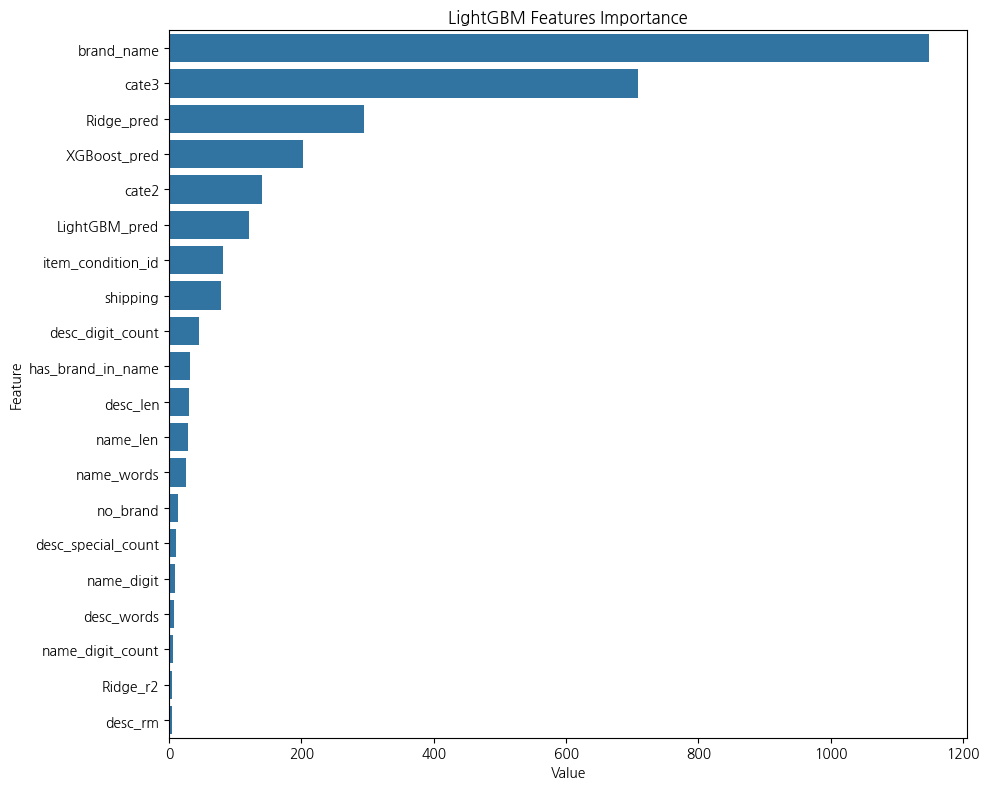

In [97]:
# LightGBM의 변수 중요도 추출
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])

# 중요도 순으로 정렬 (상위 20개만)
plt.figure(figsize=(10, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.show()

In [98]:
# 1. 예측 수행 (Log 스케일)
pred_log = model.predict(test_final[features])
actual_log = test_final['log_price']

# 2. [평가지표 1] 로그 스케일에서의 점수 (학술적 비교용)
rmse_log = np.sqrt(mean_squared_error(actual_log, pred_log))
r2 = r2_score(actual_log, pred_log)

print(f"=== 로그 스케일 평가 ===")
print(f"R2 Score (설명력): {r2:.4f} (1에 가까울수록 좋음)")
print(f"RMSE (로그 오차): {rmse_log:.4f} (0에 가까울수록 좋음)")

# 3. [평가지표 2] 실제 가격(Real Price)으로 환산한 오차 (체감용)
# 중요: np.expm1()을 써서 로그를 벗겨냅니다.
pred_real = np.expm1(pred_log)
actual_real = np.expm1(actual_log)

rmse_real = np.sqrt(mean_squared_error(actual_real, pred_real))

print(f"\n=== 실제 가격 기준 평가 ===")
print(f"RMSE (평균 오차 금액): ${rmse_real:.2f}")

=== 로그 스케일 평가 ===
R2 Score (설명력): 0.6504 (1에 가까울수록 좋음)
RMSE (로그 오차): 0.4426 (0에 가까울수록 좋음)

=== 실제 가격 기준 평가 ===
RMSE (평균 오차 금액): $25.62


# 추가로 할 것
1. 동일 모델 다른 시드 모델링
2. 글 전체로 모델링 해보기 + 결과에 따라 README 고치기
3. 베이스 모델을 다르게 설정한 이유